In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Index
- [First exploratory analysis](#First-exploratory-analysis)
    - [Add some useful columns](#Add-some-useful-columns)
    - [Check number of active cars](#Check-number-of-active-cars)
    - [A glance on the distributions of speed and cars number](#A-glance-on-the-distributions-of-speed-and-cars-number)
    - [Speed and cars number together](#Speed-and-cars-number-together)
- [Building the grid](#Building-the-grid)
    - [Assigning cell numbers](#Assigning-cell-numbers)
    - [Show grid on the map](#Show-grid-on-the-map)
    - [Perform subselection of cells](#Perform-subselection-of-cells)
    - [Plot the new grid](#Plot-the-new-grid)
- [First attempts with TL](#First-attempts-with-TL)
    - [Plotting the daily TL](#Plotting-the-daily-TL)
- [Sum it up](#Sum-it-up)
- [Creating the dataset](#Creating-the-dataset)
    - [Building the feature vector](#Building-the-feature-vector)
    - [Discard some hours](#Discard-some-hours)
    - [Calculate the 7th and 8th features](#Calculate-the-7th-and-8th-features)
- [Model creation](#Model-creation)
    - [Feature scaling](#Feature-scaling)
    - [Look at the target variable](#Look-at-the-target-variable)

# First exploratory analysis

In [2]:
# LOAD THE TURIN FILE. This may take a while

turin_file_path = 'turin_june.csv'
turin_june = pd.read_csv(turin_file_path, parse_dates=['recording_date'])

In [3]:
print("We've got %d different cars" %turin_june.device_id.nunique())

We've got 20158 different cars


In [4]:
print('The dataset timestamp range goes from %s to %s' %(
    str(turin_june.recording_date.min()), str(turin_june.recording_date.max())))

The dataset timestamp range goes from 2017-06-01 00:00:00 to 2017-06-30 21:59:49


### Add some useful columns
- `day`: UTC date without the time stamp
- `day_of_the_week`: day of the week encoded as an integer (Monday = 1)
- `hour`: only the hour of recording
- `hour_and_half`: the time stamp floored to the nearest hour and half. For instance, 11:32 would become 11:30 and 11:27 would become 11:000

In [5]:
from datetime import time

turin_june['day'] = turin_june.recording_date.dt.date
turin_june['day_of_the_week'] = turin_june.recording_date.dt.weekday + 1
turin_june['hour'] = turin_june.recording_date.dt.hour
turin_june['hour_half'] = turin_june.recording_date.dt.time.apply(lambda t: time(t.hour, (t.minute // 30)*30))

### Check number of active cars

Creating a plot for the number of active cars in each day of june. The figure will be saved under the chosen `figurepath` and its size is determined by the `fig_size` tuple

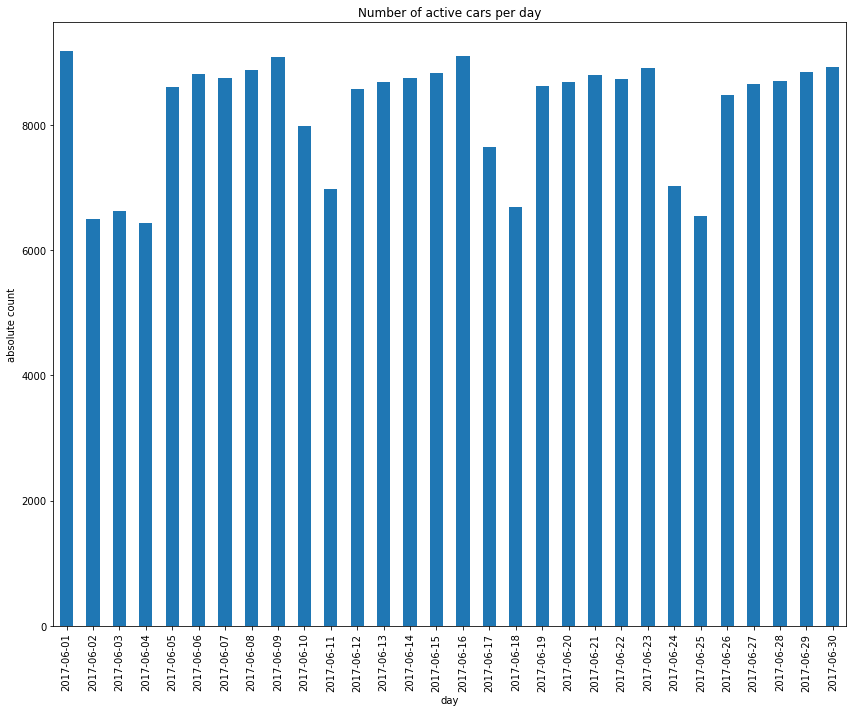

In [6]:
figurepath = 'active_cars.png'
fig_size = (12, 10)

ax = turin_june[turin_june.engine_status == 1].groupby('day').agg({'device_id': 'nunique'})\
.plot(kind='bar',  figsize=fig_size, title='Number of active cars per day')

ax.legend_.remove()
plt.ylabel('absolute count')
plt.tight_layout()
plt.savefig(figurepath)

### A glance on the distributions of speed and cars number

We first define an utility functions that plots the distributions of speed aggrageted by the desired timestamp (it can be hours, weekday or hour and half)

In [42]:
def avg_speed_dist(data, mode='hour', plotting=True):
    """Plots the histogram of speed values aggregated by the time stamp specified in the mode parameter.
    Also returns the median and average values.
    :param data: pandas DataFrame; the input dataset
    :param mode: string; the kind of time stamp according to wich aggregating the values. Possible modes:
    'hour', 'weekday', 'hour_half'
    :param plotting: boolean; to have the plots as output or not
    :return : tuple of 2 lists; the first are the medians, the second the means"""

    medians = []
    avgs = []

    if mode == 'hour':
        for h in range(0, 24, 1):
            i = int(h/4)
            j = h%4
            df = data[data.hour == h].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                fig = plt.figure(figsize=(20, 30));
                axes = fig.subplots(6, 4);
                df.plot(kind='hist', title='Avg speed at %d:00' % h, ax=axes[i, j], bins=15)
    elif mode == 'weekday':
        for d in range(1, 8):
            i = int((d-1)/2)
            j = (d-1)%2
            df = data[data.day_of_the_week == d].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                fig = plt.figure(figsize=(10, 30));
                axes = fig.subplots(4, 2);
                df.plot(kind='hist', title='Avg speed at day %d of the week' % d, ax=axes[i, j], bins=15)
                
    elif mode == 'hour_half':
        for n, hh in enumerate(sorted(data.hour_half.unique())):
            i = int((n - 1) / 4)
            j = (n - 1)%4
            df = data[data['hour_half'] == hh].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                fig = plt.figure(figsize=(10, 40));
                axes = fig.subplots(12, 4);
                df.plot(kind='hist', title='Avg speed at %s' % str(hh), ax=axes[i, j], bins=15)
            
    if plotting:
        plt.tight_layout()
        plt.show()
    return medians, avgs

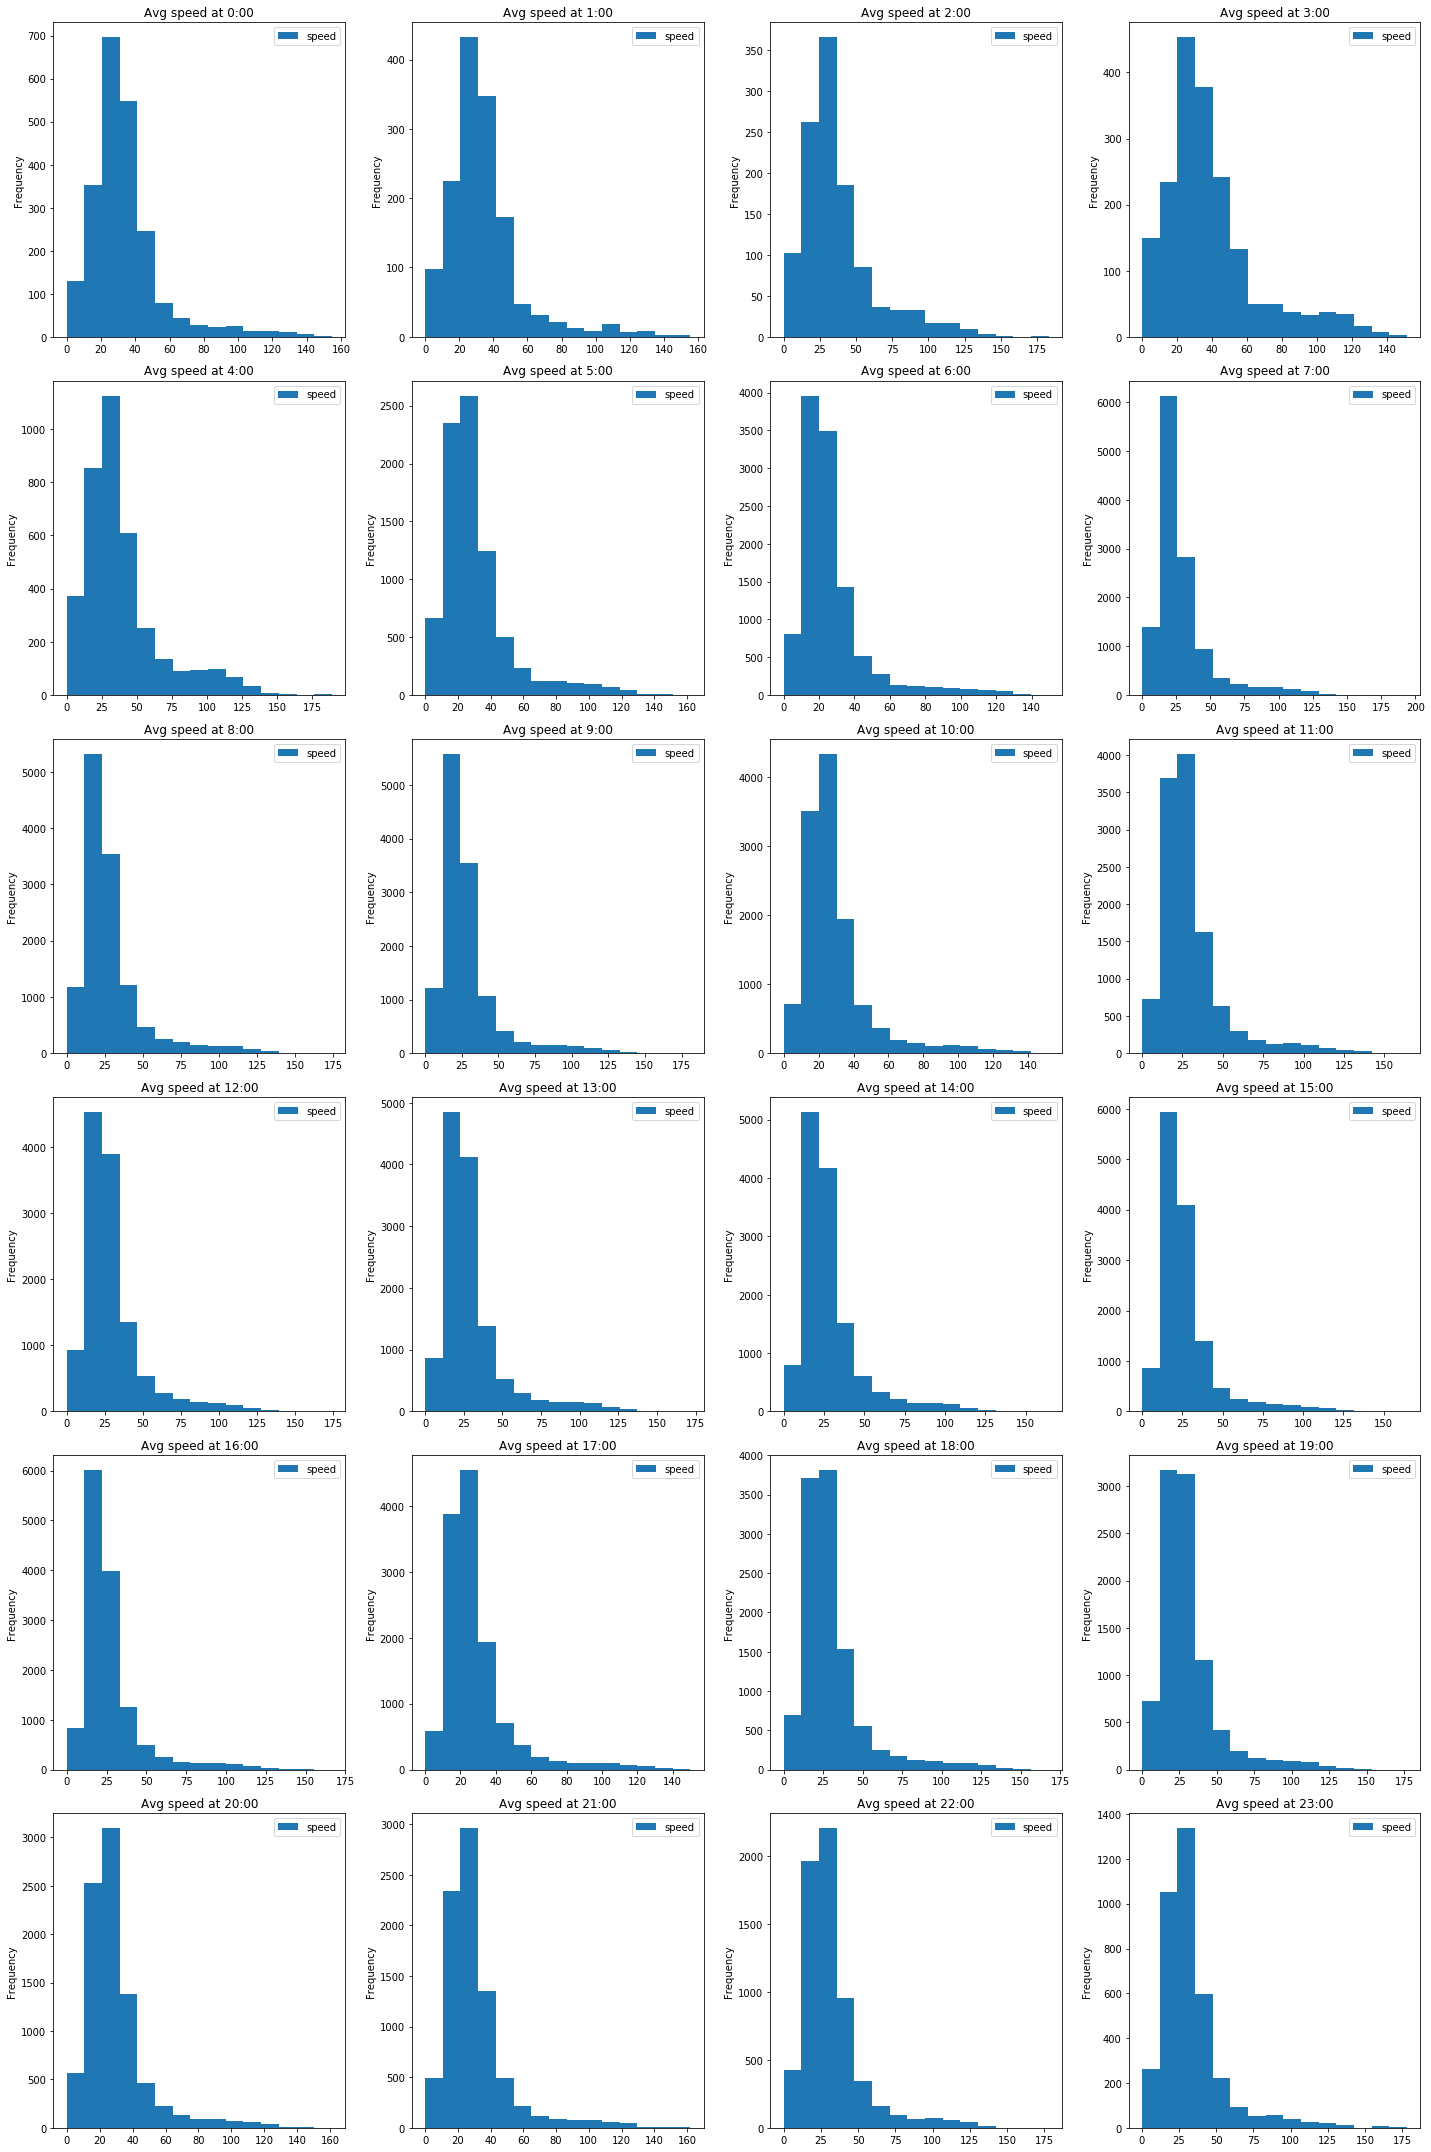

In [8]:
## See average speed by hour of the day, weekends included

medians, avgs = avg_speed_dist(turin_june[turin_june.engine_status == 1])

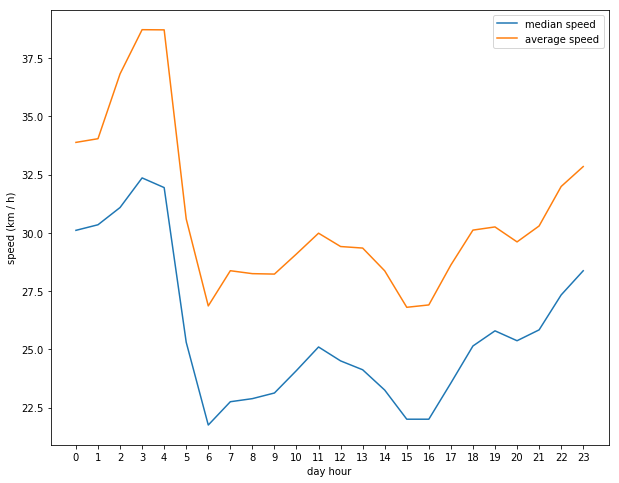

In [9]:
## Plot median and average of speed distribution by hour of the day

plt.figure(figsize=(10, 8))
plt.plot(range(0, 24), medians, label='median speed')
plt.plot(range(0, 24), avgs, label='average speed')
plt.xticks(range(0, 24))
plt.xlabel('day hour')
plt.ylabel('speed (km / h)')
plt.legend()

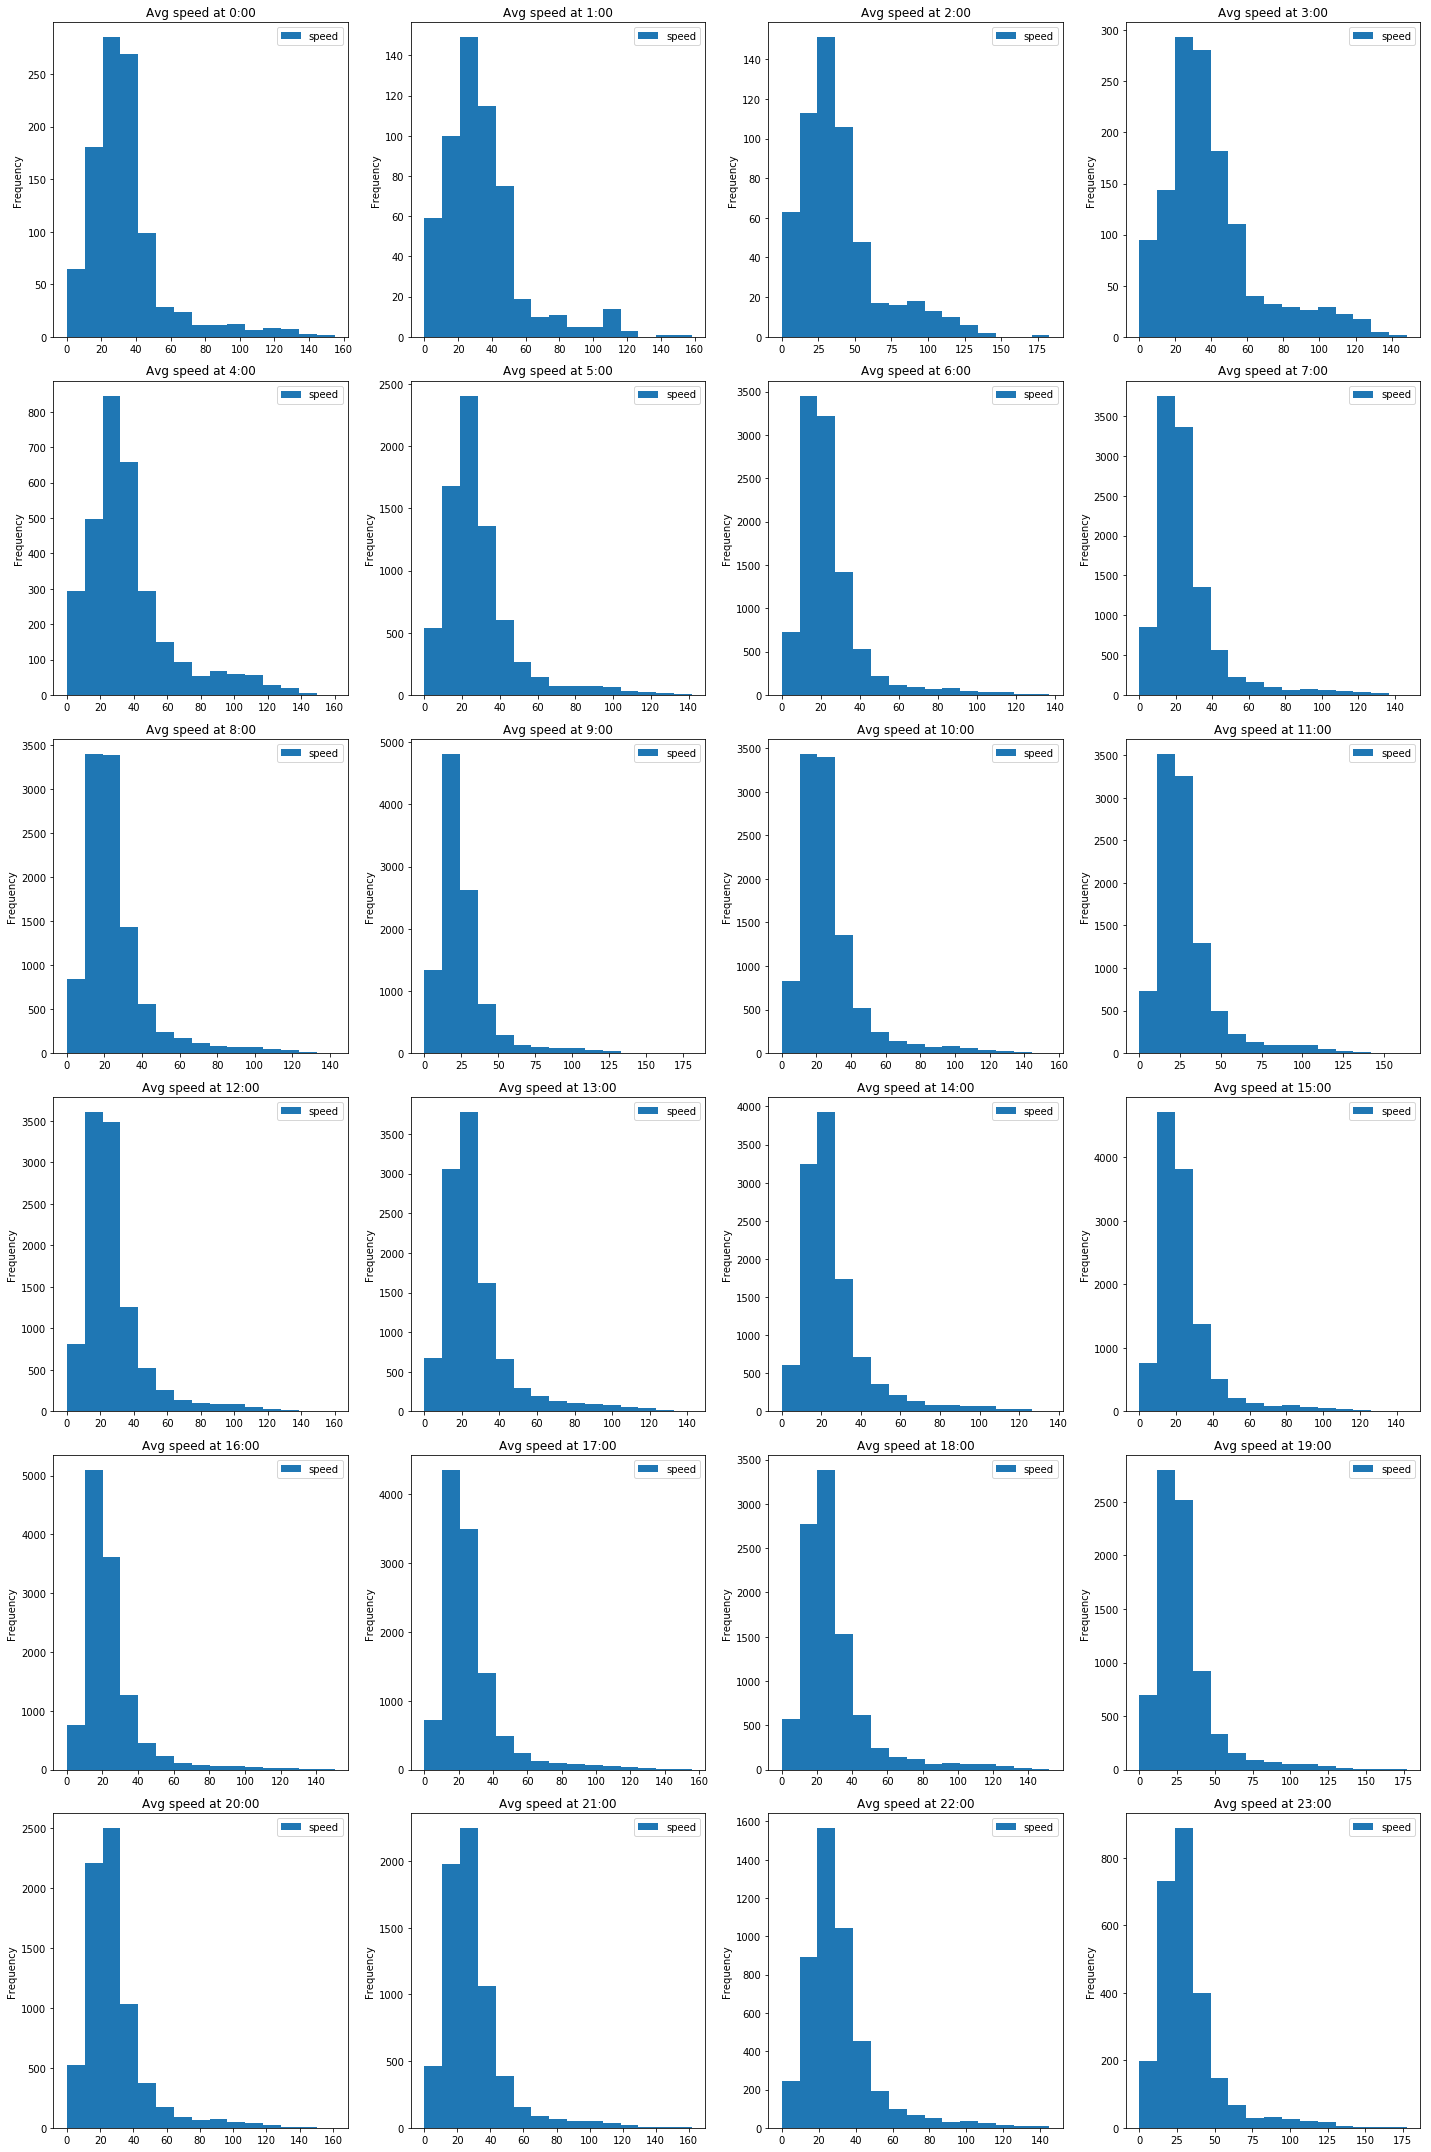

In [10]:
## Plot speed distributions by hour of the day, excluding weekends and festivities

medians2, avgs = avg_speed_dist(turin_june[(turin_june.engine_status == 1) &
                                          (~turin_june.day_of_the_week.isin([6, 7])) &
                                          (turin_june.day != date(2017, 6, 2))])

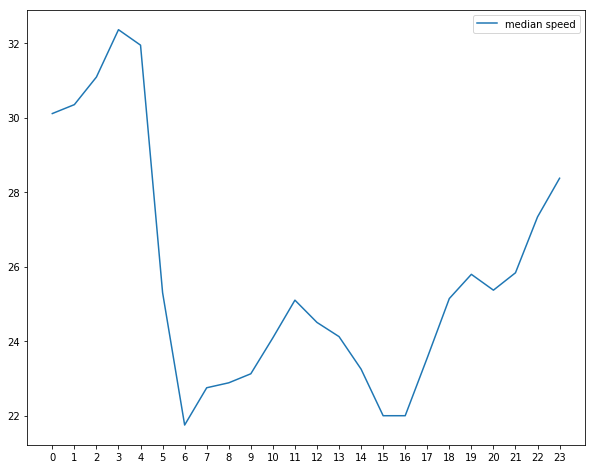

In [11]:
## Plot median distribution by hour of the day, weekends and festivity excluded

plt.figure(figsize=(10, 8))
plt.plot(range(0, 24), medians, label='median speed')
plt.xticks(range(0, 24))
plt.legend()

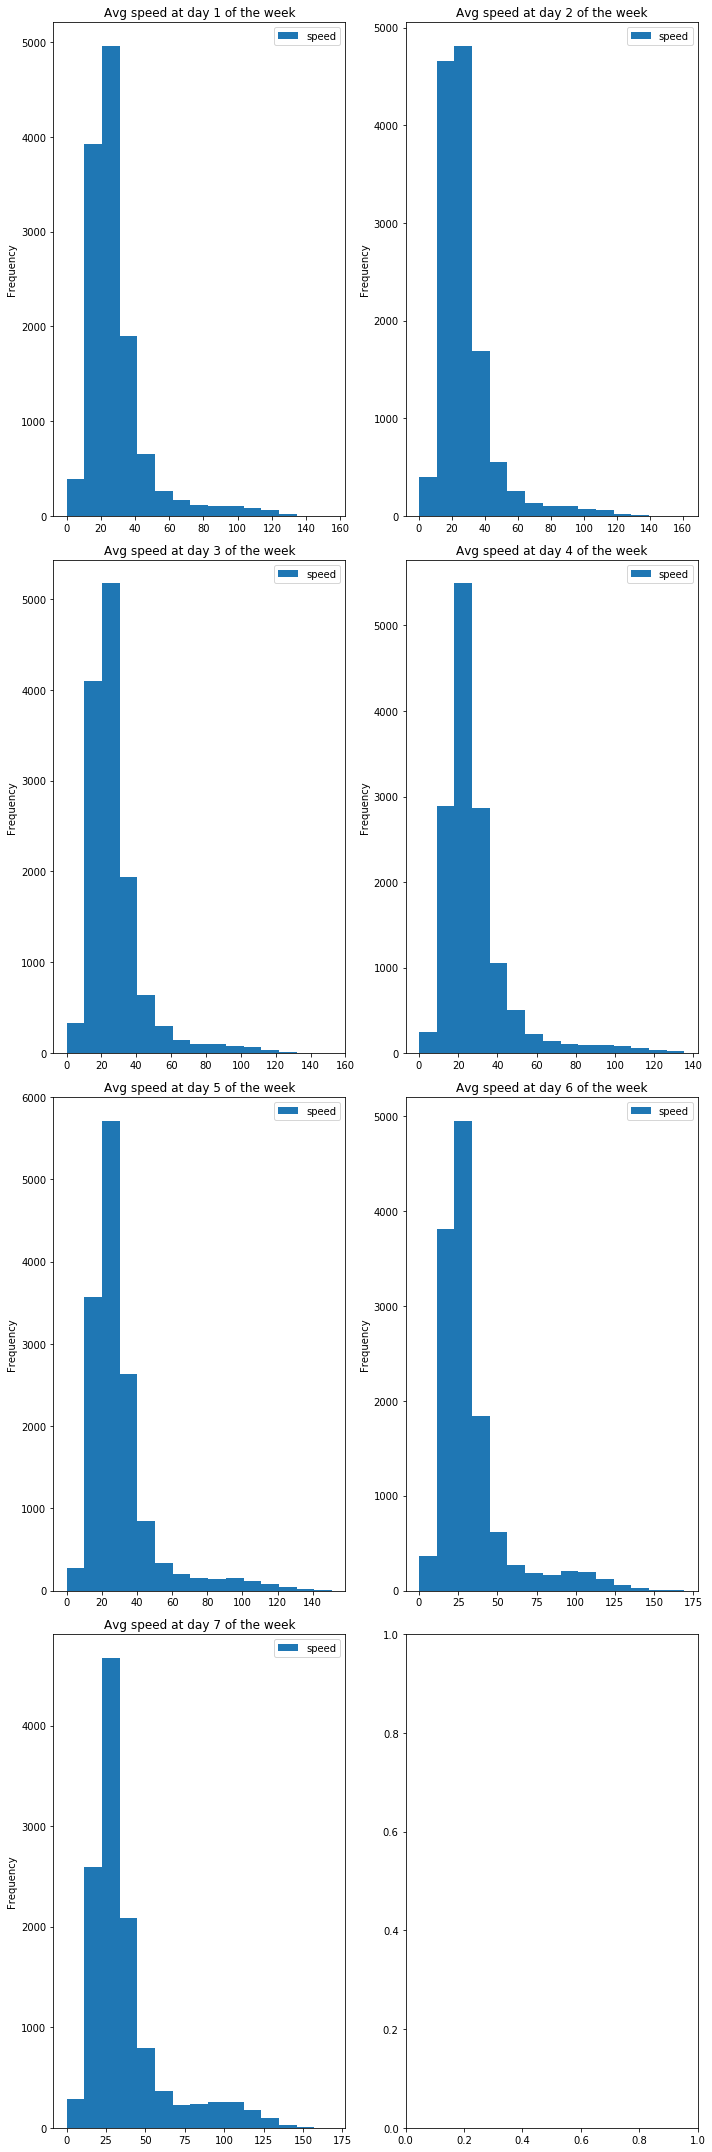

In [12]:
## Plot speed distributions by day of the week

medians_weekday, _ = avg_speed_dist(turin_june[turin_june.engine_status == 1], mode='weekday')

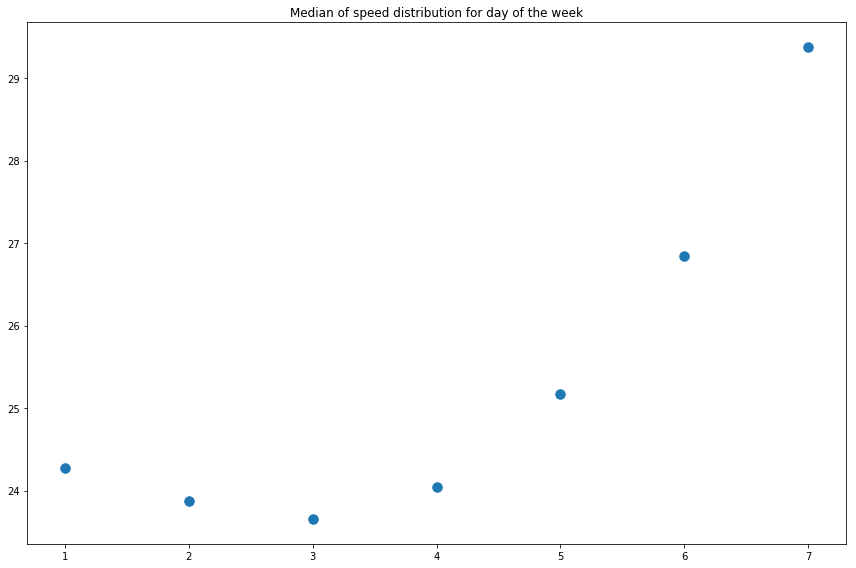

In [13]:
## Plot median speed values by day of the week, and save it under the figurepath specification
figurepath = 'scatter_med_speed_by_weekday.png'

figure(figsize=(12, 8))
plt.scatter(range(1, 8), medians_weekday, label='median speed', s=90)
plt.title('Median of speed distribution for day of the week')
plt.tight_layout()
plt.savefig(figurepath)

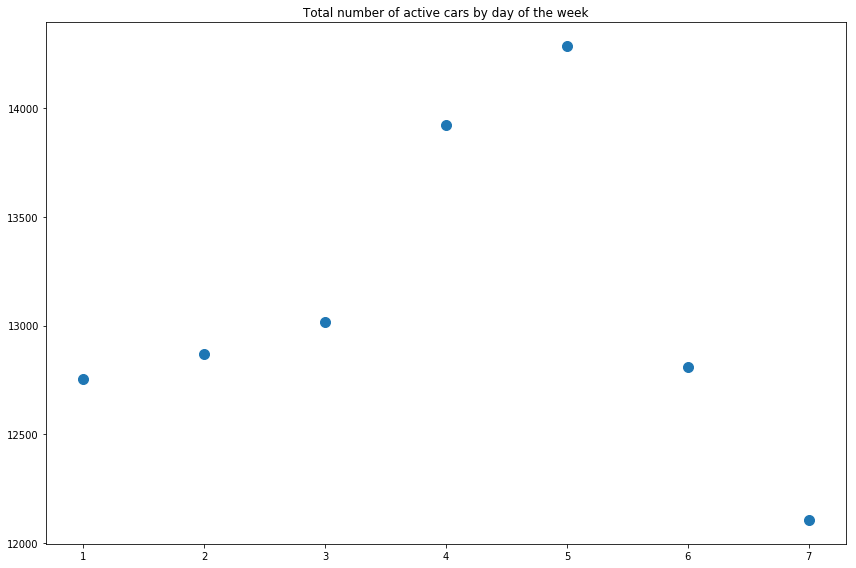

In [14]:
#Show number of active cars by day of the week and save it on the path given by figurepath
figurepath = 'active_cars_by_day.png'

figure(figsize=(12, 8))

# Compute the the number of active cars by grouping by day of the week, then save them in a list
num_of_cars = turin_june[(turin_june.engine_status == 1)].groupby('day_of_the_week').agg({'device_id': 'nunique'})\
.device_id.tolist()

plt.scatter(range(1, 8), num_of_cars, label='number of cars', s=100)
plt.title('Total number of active cars by day of the week')
plt.tight_layout()
plt.savefig(figurepath)

### Speed and cars number together
After seeing the graphs above, we first plot in the same figure the number of active cars and the median speed by hour of the day.  
Afterwards, we look for the existence of any (linear) correlation between the two.

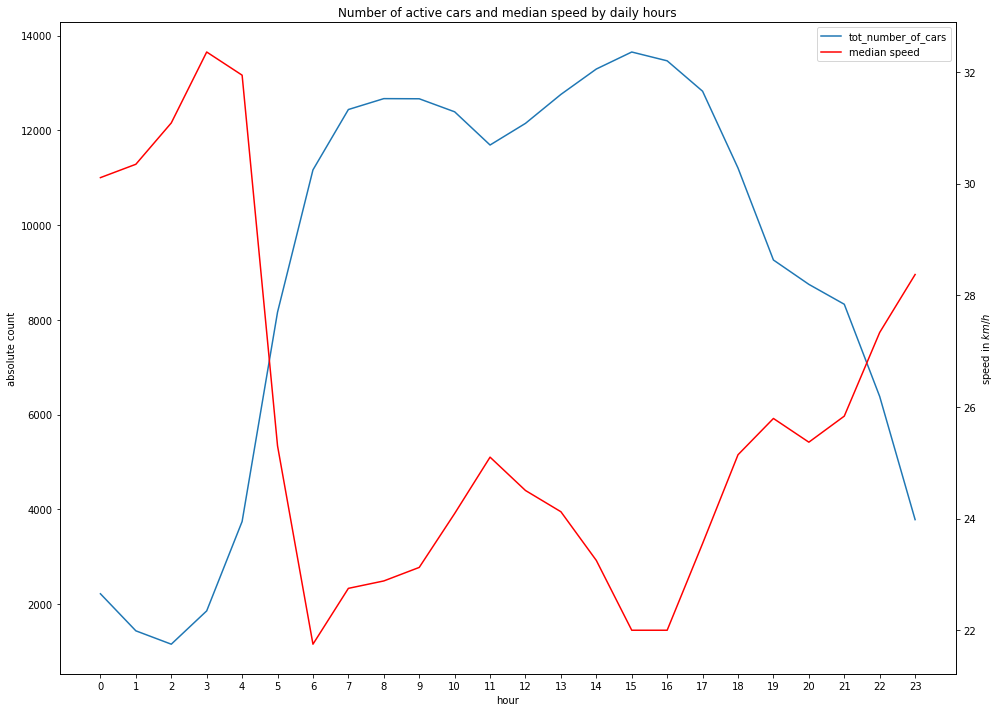

In [15]:
# Plots number of active cars and median speed, aggregated by hour. Saves the resulting graph under figurepath
figurepath = 'double_plot.png'

# create matplotlib figure and axis
fig, ax1 = plt.subplots()

# compute the number of active cars via aggregation by hour, then plot it using 
turin_june[(turin_june.engine_status == 1)].groupby('hour', as_index=False).agg({'device_id': 
                                                                                 'nunique'})\
.plot(kind='line', x='hour', y='device_id', figsize=(14, 10), label='tot_number_of_cars',
     ax=ax1)
ax1.set_xticks(range(24))
ax2 = ax1.twinx()          # generate a second matplotlib axis that shares the same x with first axis
                           # this is done to plot together y values with different orders of magnitude

ax2.plot(range(0, 24), medians, label='median speed', c='r')
ax1.set_ylabel('absolute count')
ax2.set_ylabel('speed in ' + '$km/h$')

# return the legends
ax1.legend()
ax2.legend()
# save the handles and labels inside the legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

# remove the legend from ax2 in order to show one unique legend, and not two distinct ones (1 for each axis)
ax2.legend_.remove()
ax1.legend(h1 + h2, l1 + l2)
plt.title('Number of active cars and median speed by daily hours')
plt.tight_layout()
plt.savefig(figurepath)

Pearson coefficient is -0.949 and its square is 0.900, while we have a p-value of 0.0000


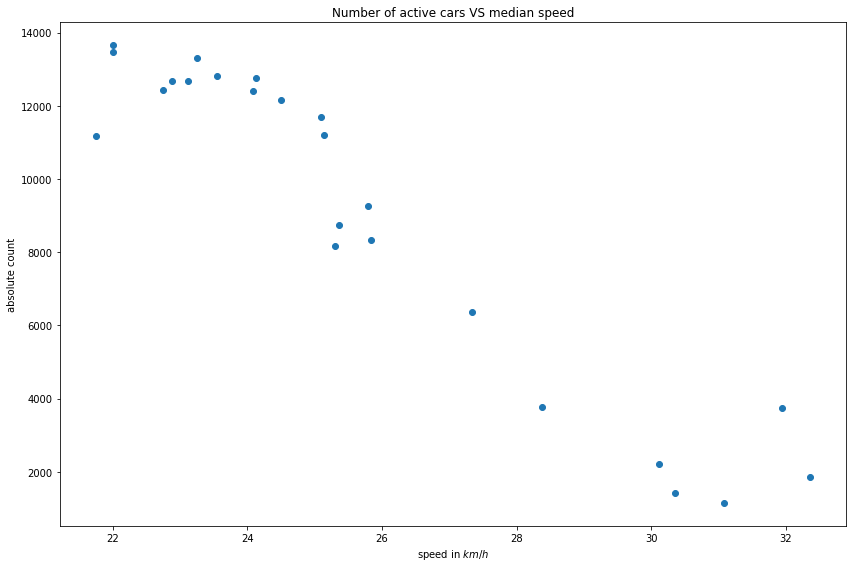

In [16]:
# Makes a scatter plot of number of distinct cars and median speed by hour. Computes linear correlation
# Save plot under figurepath

figurepath = 'ncars_&_speed_scatter_plot.png'

from scipy.stats import pearsonr  # import the function for computing pearson coefficient 

n_cars = turin_june[(turin_june.engine_status == 1)].groupby('hour', as_index=False)\
.agg({'device_id': 'nunique'}).device_id.tolist()

figure(figsize=(12, 8))
plt.scatter(medians, n_cars)

r, pv = pearsonr(medians, n_cars)
print('Pearson coefficient is %.3f and its square is %.3f, while we have a p-value of %.4f' % (r, r**2, pv))
plt.title('Number of active cars VS median speed')
plt.ylabel('absolute count')
plt.xlabel('speed in $km / h$')
plt.tight_layout()
plt.savefig(figurepath)

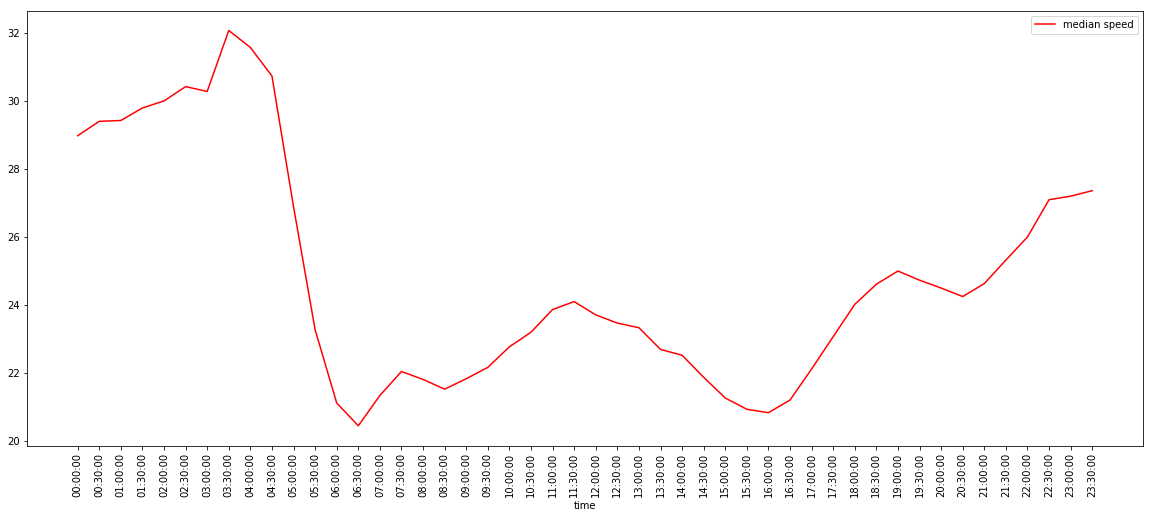

In [43]:
## Look at peaks and bottoms of speed with more time granularity (every half an hour)
## NOTE: aggregating by hour-and-halfs MAY TAKE SOME TIME

medians_half, _ = avg_speed_dist(turin_june[turin_june.engine_status == 1], mode='hour_half', plotting=False)

fig = figure(figsize=(20, 8))
tick = sorted(turin_june.hour_half.unique())
plt.plot(tick, medians_half, label='median speed', c='r')
plt.xticks(tick, tick, rotation='vertical')
plt.legend();

```python
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(temp['lon'], temp['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()
```

# Building the grid

We decide to build the grid by simply flooring the latitude and longitude values in the dataset at a specific decimal point. We decide to floor the longitude to the nearest 0.005 multiple, and to floor the latitude to the nearest 0.0025 multiple. So for the longitude we want, for instance  
```python
special_floor(7.458) = 7.455
special_floor(7.461) = 7.460
```  
and for the latitude something like
```python
special_floor2(45.5564) = 45.5560
special_floor2(45.5566) = 45.5565
```  

In [18]:
def special_floor(n):
    return round(floor(n * 400)/400, 4)

def special_floor2(n):
    return round(floor(n * 200)/200, 3)

In [19]:
# Map every position in the dataset to the corresponding cell in the grid.
# By the flooring approach, what we get from the mapping is the low-left angle of the rectangular cells

turin_june['grid_lon'] = turin_june.lon.apply(lambda l: special_floor2(l))
turin_june['grid_lat'] = turin_june.lat.apply(lambda l: special_floor(l))

### Assigning cell numbers
Now that every longitude and latitude pair has been mapped to the corresponding cell (more exactly, to the low-left angle coordinates of each cell, we extract the row and column number of each cell in the grid. Row and column numbers will be helpful to find a cell's neighbours: given that the grid has a total number of columns `n_cols`, considering a cell with position `(i, j)` in the grid, its neighbours will have the following row and column numbers:  
![img](cell_and_neighs.png)

In [20]:
# In the two lines below, the multiplication to 200 and 400 is needed in order to take into consideration
# that longitude and latitude are truncated by flooring to nearest 0.005 and 0.0025, respectively
turin_june['col_number'] = ((turin_june.grid_lon - turin_june.grid_lon.min()) * 200).round().astype(int)
turin_june['row_number'] = ((turin_june.grid_lat - turin_june.grid_lat.min()) * 400).round().astype(int)

tot_cols = turin_june.col_number.max()

# We get the cell number (an integer ranging from 0 to tot_rows x tot_cols) and the coordinates of cell centroids
turin_june['cell_number'] = (turin_june.row_number*tot_cols) + turin_june.col_number
turin_june['cell_centroid_lat'] = turin_june.grid_lat + 0.00125
turin_june['cell_centroid_lon'] = turin_june.grid_lon + 0.0025

In [21]:
# Set a threshold to select meaningful rows

agg_speed = agg_speed[agg_speed.n_cars >= 10].reset_index()
tl_c = agg_speed.n_cars / agg_speed.speed
tl_r = agg_speed.n_records / agg_speed.speed
agg_speed['TL_r'] = tl_r
agg_speed['TL_c'] = tl_c

NameError: name 'agg_speed' is not defined

In [ ]:
traffic_level = agg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_r': np.mean, 'TL_c': np.mean})

In [ ]:
fig = plt.figure(figsize=(18, 30))
hours = sorted(traffic_level.hour_half.unique())
axes = fig.subplots(4, 2)
for d in range(1, 8):
    i = int((d-1)/2)
    j = (d-1)%2
    traffic_level[traffic_level.day_of_the_week == d].plot(x='hour_half', y='TL_r', ax=axes[i,j], label='TL_r', rot=90)
    #traffic_level[traffic_level.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i,j], label='TL_c', rot=90)
    distinct_tl[distinct_tl.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i, j], label='TL_c', rot=90)
    axes[i, j].set_xticks(hours)
    axes[i, j].legend()

### Show grid on the map

In [29]:
import shapely
import imp 
import folium
import seaborn as sns

name_start_point = "origin_point"
name_end_point = "dest_point"

max_lon = turin_june.grid_lon.max()
min_lon = turin_june.grid_lon.min()
max_lat = turin_june.grid_lat.max()
min_lat = turin_june.grid_lat.min()
            
lines = []

lat = min_lat
while lat <= max_lat + 0.01:
    lines.append([[lat, min_lon], [lat, max_lon]])
    lat += 0.0025
    
lon = min_lon
while lon <= max_lon:
    lines.append([[min_lat, lon],[max_lat + 0.01, lon]])
    lon += 0.005

map_folium =  folium.Map(location = [ (max_lat + min_lat)/2, (max_lon + min_lon)/2], zoom_start=11)

map_folium.add_child(folium.PolyLine(lines, weight=1.5))

"""for c, locs in enumerate(cent_coords):
    folium.CircleMarker(locs, radius=2).add_to(map_folium)
for c, locs in enumerate(strange_coords):
    folium.CircleMarker(locs, radius=2, color='#f53107').add_to(map_folium)"""

map_folium

In [24]:
# Show the size of the grid, and the total size
rows = turin_june.col_number.max() + 1
cols = turin_june.row_number.max() + 1
rows, cols, 'Total number of cells is %d' % (rows * cols)

(40, 55, 'Total number of cells is 2200')

### Perform subselection of cells
At this point we noticed that many cell were undervisited, i.e. the number of distinct cars crossing them during the month was too low in order to build a reliable estimations. So we computed a *cell density*, as the avarage number of distinct cars crossing the cell every day. We avaraged on the whole month of june, and after using the `describe()` method on the dataset, we selected **175** as threshold

In [26]:
## Valuate cell density
## The first groupby counts the number of distinct cars in the cell,
## the second takes the average on the whole month

cell_density = turin_june[turin_june.engine_status == 1]\
.groupby(['cell_number', 'day'], as_index=False).agg({'device_id': 'nunique'})\
.groupby('cell_number', as_index=False).agg({'device_id': np.mean}).rename(columns={'device_id': 'car_density'})

In [27]:
cell_density.car_density.describe()

count    2100.000000
mean      109.144178
std       131.118858
min         1.000000
25%         5.983333
50%        55.566667
75%       171.233333
max       780.600000
Name: car_density, dtype: float64

In [28]:
# Get numbers of high density (hd) cells and their coordinates

hd_cells = cell_density[cell_density.car_density >= 175].cell_number.unique()
print('We started with %d high density cells' % len(hd_cells))

# Get rid of lonely cells. We keep only the cells that have at least 1 out of all 8 possible neighbours

cell_list = hd_cells.tolist()

for c in hd_cells:
    neighs = [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]
    s = 0
    for n in neighs:
        s += (hd_cells == n).sum()  # check if in the hd_cells there's at least one neighbour
    if s == 0:
        cell_list.remove(c)         # otherwise remove the cell
        
hd_coords = turin_june.loc[turin_june.cell_number.isin(cell_list), ['cell_number','grid_lat', 'grid_lon']]\
.drop_duplicates(subset=['cell_number']).drop('cell_number', 1).values

print('We ended up with %d high density cells' % hd_coords.shape[0])

We started with 514 high density cells
We ended up with 500 high density cells


In [175]:
cent_coords = turin_june.loc[turin_june.cell_number.isin(cell_list), ['cell_number','cell_centroid_lat', 'cell_centroid_lon']]\
.drop_duplicates(subset=['cell_number']).drop('cell_number', 1).values

In [185]:
strange_coords = turin_june.loc[turin_june.cell_number.isin(strange_cells[:10]), ['cell_number','cell_centroid_lat', 'cell_centroid_lon']]\
.drop_duplicates(subset=['cell_number']).drop('cell_number', 1).values

### Plot the new grid

In [31]:
lines = []

def point_on_right(locs):
    """Returns the cell angle on the right, having same latitude as input"""
    return [locs[0], round(locs[1] + 0.005, 4)]

def point_up(locs):
    """Returns the cell angle above, having same longitude as input"""
    return [round(locs[0] + 0.0025, 4), locs[1]]

for row in hd_coords:
    row = row.tolist()
    left_up = point_up(row)
    right_up = point_on_right(left_up)
    right_down = point_on_right(row)
    # left up line
    lines.append([row, left_up])
    # up right line
    lines.append([left_up, right_up])
    # down right line
    lines.append([row, right_down])
    # right up line
    lines.append([right_down, right_up])

map_folium =  folium.Map(location = [ (max_lat + min_lat)/2, (max_lon + min_lon)/2], zoom_start=11)

map_folium.add_child(folium.PolyLine(lines, weight=1.5))

map_folium

# First attempts with TL
We first try to look at the traffic level for the whole city. We want to compute the traffic level `TL` for a cell `c` at a timestamp `t` as  
$$TL(c, t) = {N(c, t) \over \langle v \rangle}$$
where `N` is the number of different cars in cell `c` at moment `t` divided by the average speed of those cars. This computation implies having **one** instance per car for each pair (`c`,`t`), but for cell with size 400m X 250 m and a selected time window of **30 minutes**, we'll probably have more than one recording for each car in our spatial and temporal range. So we first take the arithmetic mean of the car speed in the time window (step **1**)  
After that, we aggragate by day of the week, time window and cell number in order to take average values of $N$ and $\langle v \rangle$, as defined above (step **2**).   
At last, we group by day of the week and timestap (i.e. each half-an-hour) in order to lose the spatial dependency (step **3**) and having the TL for the whole city, depending on day of the week and the specific hour and half.

In [45]:
cell_ncars_and_speed = turin_june[
    (turin_june.engine_status == 1) &
    turin_june.cell_number.isin(hd_cells)].groupby(['day_of_the_week',                          # step 1
                                                    'hour_half', 'cell_number', 
                                                    'device_id'], as_index=False)\
.agg({'speed': np.mean}).groupby(['day_of_the_week',                                            # step 2
                                  'hour_half', 'cell_number'])\
.agg({'speed': np.mean, 'device_id': 'nunique'})\
.rename(columns={'device_id': 'n_cars'}).reset_index()

cell_ncars_and_speed = cell_ncars_and_speed.loc[cell_ncars_and_speed.speed > 0]                 # discard rows with 
                                                                                                # speed = 0
    
cell_ncars_and_speed['TL_c'] = cell_ncars_and_speed.n_cars / cell_ncars_and_speed.speed         # computing TL
all_turin_tl = distinct_avg_speed.groupby(['day_of_the_week', 'hour_half'], as_index=False)\
.agg({'TL_c': np.mean})                                                                         # step 3

In [36]:
hours = sorted(turin_june.hour_half.unique())  # retrieve the different hours and half

### Plotting the daily TL

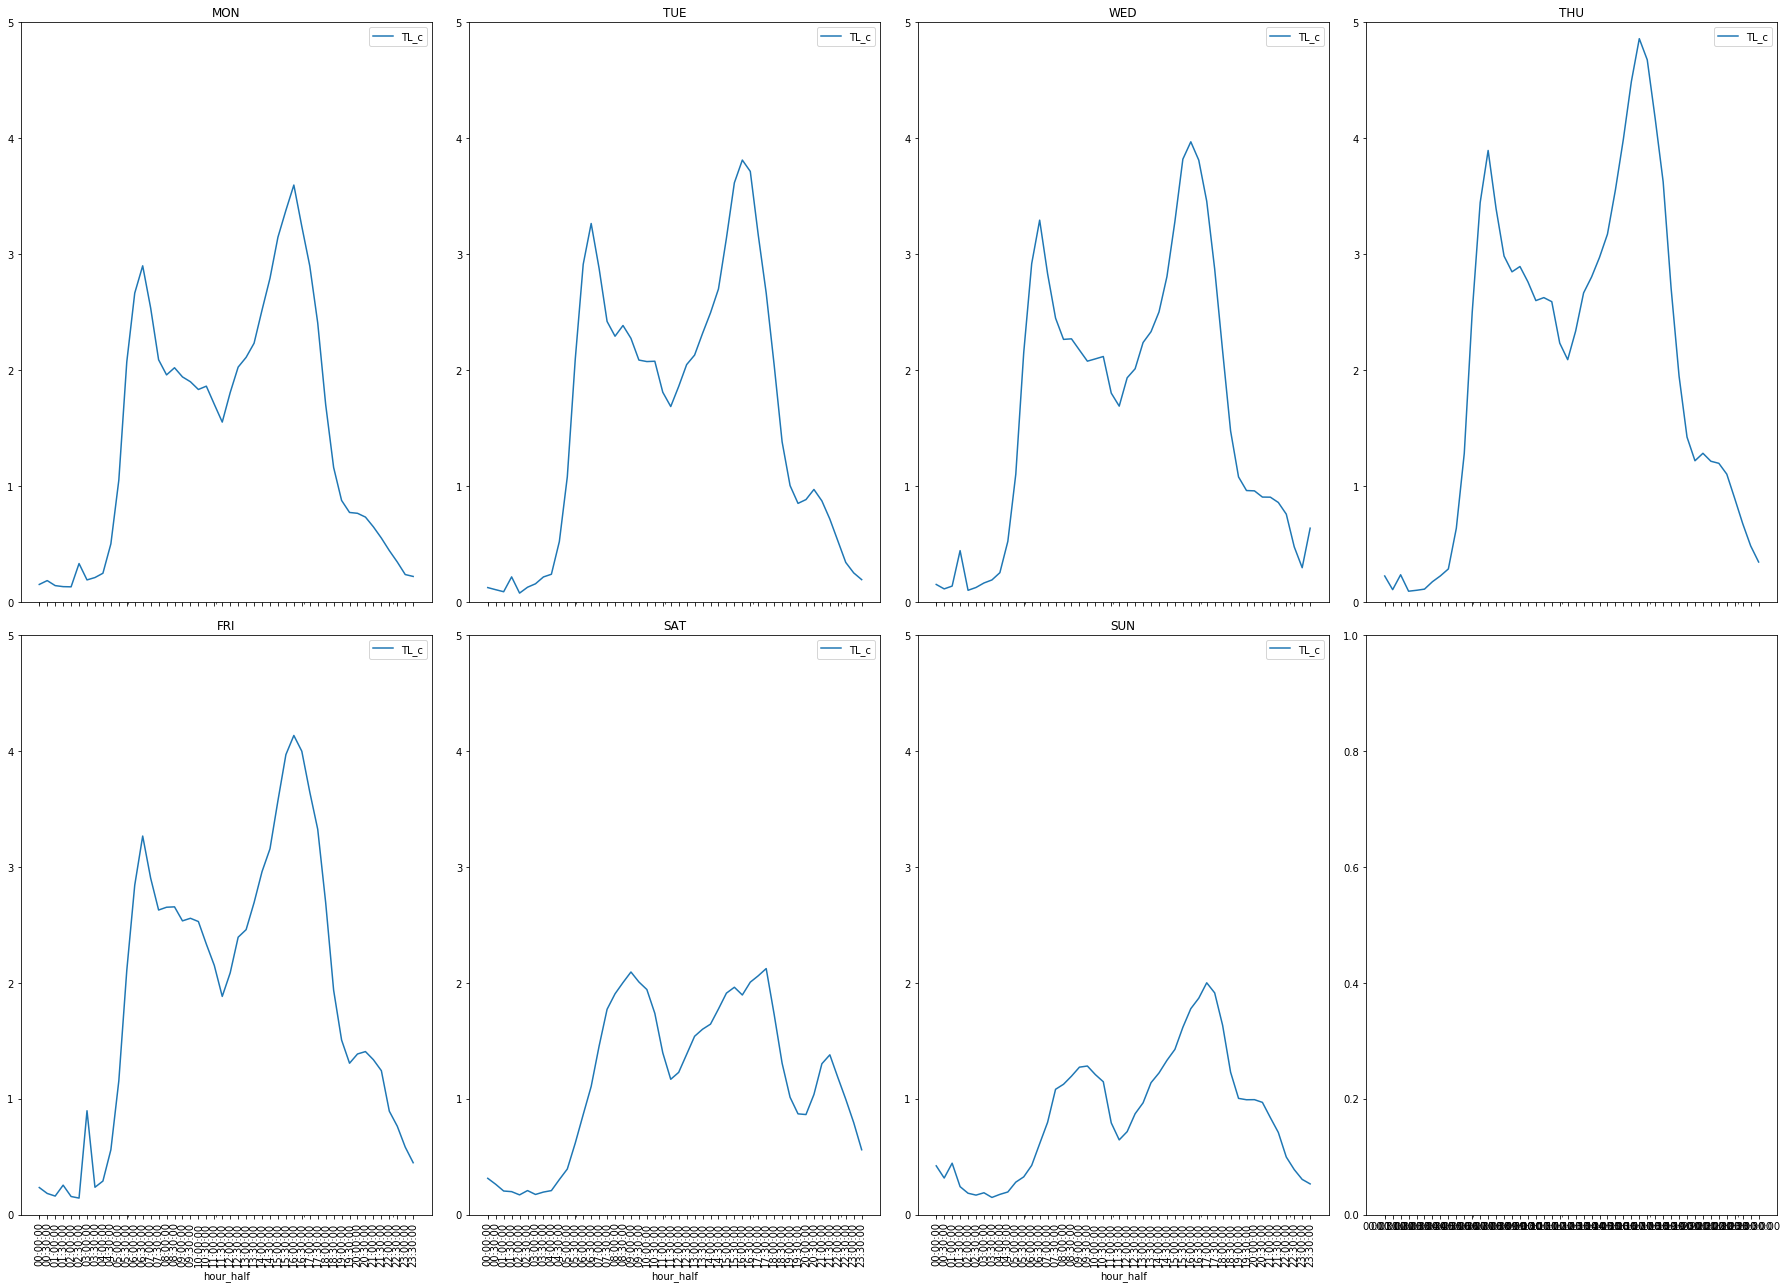

In [46]:
fig = plt.figure(figsize=(25, 18))

axes = fig.subplots(2, 4, sharex=True)
day_names = dict(zip(range(1, 8), ['MON','TUE', "WED", 'THU', 'FRI', 'SAT', 'SUN']))
for d in range(1, 8):
    i = int((d-1)/4)
    j = (d-1)%4
    distinct_tl[distinct_tl.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i, j], title=day_names[d], 
                                                       rot=90)
    axes[i, j].set_ylim(0, 5)
    axes[i, j].set_xticks(hours)
    axes[i, j].set_xticklabels(hours)
#plt.xticks(hours)
plt.tight_layout()
plt.savefig('traffic_levels_turin.png')

# Sum it up

#### What we have learned so far
1. Number of distinct cars / avg speed inside a cell seems a good metric for measuring traffic levels
2. Traffic levels computed in this way seems stable during working days, then have some peculiar shape for saturday and sunday
3. To perform analysis, we chose only the cells with higher density

#### What we can try later
1. Change the grid shape (maybe finer)
2. Change time window
3. Decide aggregation in time window (now we just keep the first value for speed)

#### What we're gonna do now
1. Build the dataset with the feature vector: `weekday`, `hour_half`, `TL_30_min_before`, `TL_left`, `TL_up`, `TL_right`, `TL_down`. If the cell has not 4 neighbours, we set the TL feature values to an average value we compute

# Creating the dataset
We now create the dataset where each row is a snapshot of a cell's traffic level in a specific period in time. Each row should be a 8-dimensional vector where:
- the first 3 dimension encode the 3 possible values of the categorical variable `day_of_the_week`: it can be *W* for working days, 'SA' for Saturday and 'SU' for Sunday
- the 4th feature is the specific hour-and-half, encoded as an integer that goes from 1 to 48
- the 5th and 6th features are the latitude and longitude of the cell's centroid
- the 7th feature is the mean TL of the cell's neighbours at the previous hour-and-half
- the 8th feature is the TL of this very same cell at the previous hour-and-half

### Building the feature vector

In [47]:
map_h_to_int = dict(zip(hours, range(1, 49)))                # dict to encode the hour-and-half as an int from 1 to 48
map_d_to_int = dict(zip(range(1,8), ['W']*5 + ['SA', 'SU'])) # dict to map the 7 values for weekdays into just 3 values

# Select only the data corresponding to the subset of cells defined above
little_turin = turin_june[(turin_june.engine_status == 1) &
                         (turin_june.cell_number.isin(cell_list))].copy()

# Transform weekdays and hours
little_turin['day_of_the_week'] = little_turin.day_of_the_week.map(map_d_to_int)
little_turin['hour_half'] = little_turin.hour_half.map(map_h_to_int)

# Compute TL for each weekday, hour and cell, and create first structure of the training dataset

dataset = little_turin\
.groupby(['day_of_the_week', 'hour_half', 'cell_number', 'device_id'], as_index=False).agg({'speed': np.mean})\
.groupby(['day_of_the_week', 'hour_half', 'cell_number'], as_index=False).agg({'device_id': 'nunique', 
                                                                               'speed': np.mean})\
.rename(columns={'device_id': 'n_cars'})

dataset.speed.describe()

count    71630.000000
mean        34.940236
std         24.098019
min          0.000000
25%         19.786194
50%         26.152265
75%         39.166667
max        180.000000
Name: speed, dtype: float64

### Discard some hours
From the previous describe we see that there are still some speed values equal to zero, that would make the TL computation go to infinity. By visual exploration we see that these low level of speed are due to cell snapshots with very few cars, expecially in hours ranging from 11.30 PM to 5.30 AM (UTC time). So we only consider hours from 5.30 to 11.30

In [49]:
## Create the dataset for rows with time = 5.00 AM (10 when encoded as an integer)
## This will be used to compute the TL values at previous time for inputs with time = 5.30 (11 when encoded)

dataset_10 = dataset.loc[(dataset.hour_half == 10)]
zero_speed_10 = dataset_10[dataset_10.speed == 0]     # save here eventual rows with 0 speed

In [50]:
# Select only hours after very early morning (5.30 AM - 11.30 PM)

dataset = dataset.loc[dataset.hour_half.between(11, 47)]

zero_speed_values = dataset[dataset.speed == 0].index    # save here eventual rows with 0 speed

In [51]:
# Compute TL for rows with speed > 0

dataset.loc[dataset.speed != 0, 'TL'] = 1. / dataset.speed
dataset_10.loc[dataset_10.speed != 0, 'TL'] = 1. / dataset_10.speed

In [52]:
## Clean row with speed == 0
## For each one, we insert a new speed values computed as the average of speeds in the neighbouring cells,
## at the same weekday and same hour-and-half

for c, h in dataset.loc[dataset.speed == 0, ['cell_number', 'hour_half']].values.tolist():
    print(c, h)
    neighs = [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]
    d = dataset[dataset.cell_number.isin(neighs)]
    if not len(d):
        print('no neigs for cell %d for hour %d' %(c, h))
    else:
        dataset.loc[(dataset.speed == 0) & (dataset.cell_number == c) & (dataset.hour_half == h),
                   'TL'] = d.TL.mean()
        
for c, h in dataset_10.loc[dataset_10.speed == 0, ['cell_number', 'hour_half']].values.tolist():
    print(c, h)
    neighs = [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]
    d = dataset_10[dataset_10.cell_number.isin(neighs)]
    if not len(d):
        print('no neigs for cell %d for hour %d' %(c, h))
    else:
        dataset_10.loc[(dataset_10.speed == 0) & (dataset_10.cell_number == c) & (dataset_10.hour_half == h),
                   'TL'] = d.TL.mean()

562 11
1454 11
1467 11
1415 12
606 13
876 13
707 46
597 10
792 10
1111 10
1179 10
1495 10


In [53]:
# Look to 10 random rows of the dataset 
dataset.sample(frac=1.).head(10)

,day_of_the_week,hour_half,cell_number,n_cars,speed,TL
13208,SA,27,1432,58,24.308046,0.041139
39086,SU,31,1525,74,99.641892,0.010036
63323,W,32,912,301,20.232420,0.049426
35764,SU,25,635,14,22.071429,0.045307
6154,SA,13,1231,17,14.200000,0.070423
15856,SA,33,292,47,62.202128,0.016077
8846,SA,19,252,27,51.209877,0.019527
63402,W,32,1077,203,20.976685,0.047672
18504,SA,38,880,46,15.010870,0.066618
44073,SU,41,1484,31,98.376344,0.010165


### Calculate the 7th and 8th features
In order to compute the required TL, we have to do many lookups to the corrisponding rows in the dataset. This process can be quite time demanding

In [54]:
def find_neighbours(c):                                                    # this finds the cell's neighbours
    return [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]

def tl_previous_half(tup):
    d = tup[0]
    h = tup[1]
    c = tup[2]
    if h == 11:
        df = dataset_10
    else:
        df = dataset
    prev_h = h - 1
    if not len(df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == d)]):
        n = find_neighbours(c)
        return df[df.cell_number.isin(n) & (df.hour_half == prev_h) & (df.day_of_the_week == d)].TL.mean()
    else:
        return df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == d)].TL.values[0]
    
def tl_neighs(tup, main_df, df_10):
    d = tup[0]
    h = tup[1]
    c = tup[2]
    if h == 11:
        df = dataset_10
    else:
        df = main_df
    h = h - 1
    n = find_neighbours(c)
    return df[df.cell_number.isin(n) & (df.hour_half == h) & (df.day_of_the_week == d)].TL.mean()

In [57]:
dataset['tl_neighs'] = dataset.iloc[:, [0, 1, 2]].apply(tl_neighs, args=(dataset, dataset_10), axis=1)

In [58]:
dataset['tl_prev_half'] = dataset.iloc[:, [0, 1, 2]].apply(tl_previous_half, axis=1)

In [59]:
# Merge the dataset with the original dataframe to obtain the cell centroid's latitude and longitude
# In the beginning we kept only the cell number to make the aggregation easier

dataset = dataset.merge(turin_june.drop_duplicates(subset=['cell_number'])[['cell_number',
                                                                            'cell_centroid_lat', 
                                                                            'cell_centroid_lon']], 
                        how='left',
                        on=['cell_number'])

dataset = dataset.iloc[:, [0, 1, 8, 9, 6, 7, 2, 3, 4, 5]]

# Model creation
Creating the predictive model, step by step

In [63]:
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from xgboost.sklearn import XGBRegressor

In [61]:
dataset = pd.get_dummies(dataset)                           # this function hot-encodes the categorical variables              
dataset = dataset.iloc[:, [-3, -2, -1] + list(range(9))]
dataset.sample(frac=1.).head(10)

,day_of_the_week_SA,day_of_the_week_SU,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,TL
16933,1,0,0,44,45.10375,7.7675,0.037107,0.029641,1559,28,38.172619,0.026197
28641,0,1,0,31,45.05625,7.6475,0.041400,0.032623,794,30,23.609524,0.042356
7382,1,0,0,25,45.09625,7.6775,0.042151,0.051417,1424,21,14.678571,0.068127
9756,1,0,0,30,45.07375,7.6075,0.042619,0.056312,1059,26,21.211538,0.047144
6280,1,0,0,23,45.07625,7.6325,0.057169,0.033251,1103,26,32.025641,0.031225
10657,1,0,0,32,45.05625,7.6875,0.058692,0.034483,802,31,29.725806,0.033641
18889,0,1,0,11,45.09875,7.6575,0.034326,0.027624,1459,5,28.500000,0.035088
36232,0,1,0,46,45.07125,7.6575,0.047296,0.037566,1030,18,15.083333,0.066298
18383,1,0,0,47,45.09625,7.6875,0.037784,0.063306,1426,19,20.614035,0.048511
43916,0,0,1,24,45.10375,7.6925,0.038351,0.029790,1544,316,35.377402,0.028267


In [93]:
dataset[['tl_neighs', 'tl_prev_half']].describe()

,tl_neighs,tl_prev_half
count,55485.000000,55485.000000
mean,0.040900,0.040749
std,0.016353,0.024964
min,0.007812,0.007246
25%,0.032713,0.027931
50%,0.043004,0.040468
75%,0.050528,0.052149
max,0.527378,2.000000


In [64]:
X, y = dataset.iloc[:, :8].values, dataset.iloc[:, -1]            # get the X (input matrix) and y (output matrix)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23) 

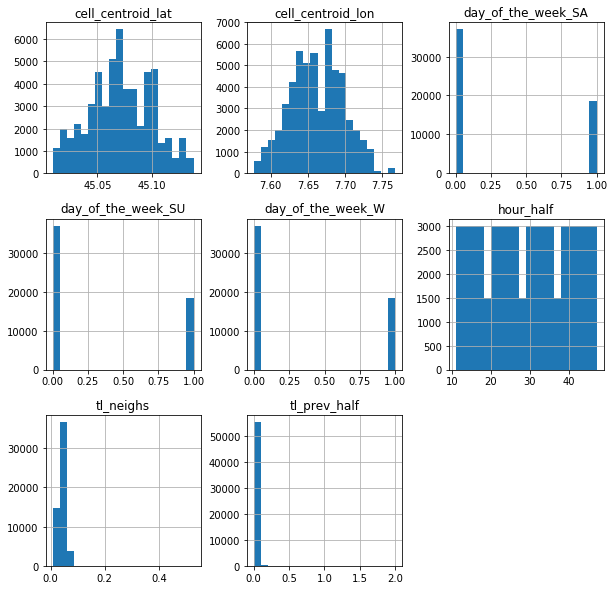

In [68]:
# Show the distributions of input features

dataset.iloc[:, :8].hist(bins=20, figsize=(10, 10));

### Feature scaling
Since the TL features seems to follow a skewed distrubution, we opt for a MinMaxScaler to uniform the data; see [here](http://benalexkeen.com/feature-scaling-with-scikit-learn/) for major info

In [69]:
scaler = MinMaxScaler()
X_trans = scaler.fit_transform(X_train)

### Look at the target variable
Look at the distribution of TL target variables

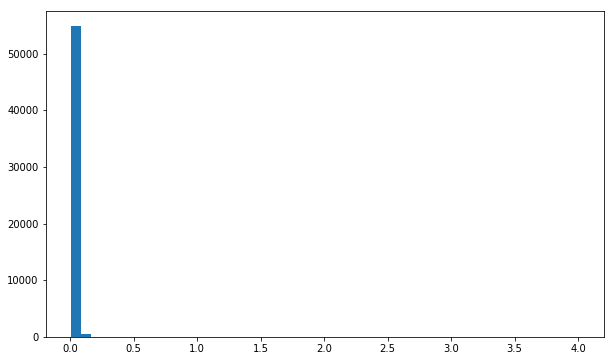

In [72]:
dataset.TL.hist(bins=50, grid=False, figsize=(10, 6))

55485


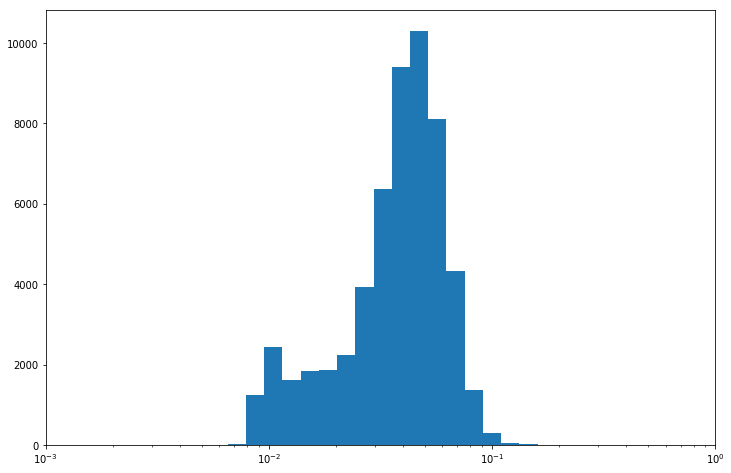

In [73]:
# It seems very skewed because of very far awau outliers. We tried to look at the log of the values
# and found put that the TL values are log distributed

dataset.TL.hist(bins=np.logspace(-3, 1, 50),grid=False, figsize=(12, 8))

plt.xlim(1e-3,1e0)
plt.xscale('log')
print(len(dataset))
perc90 = dataset.TL.quantile(0.9999)
len(dataset[dataset.TL > perc90]), perc90
plt.savefig('tlnorm.png')

In [77]:
# Log scale the y
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.2, random_state=23) 

In [74]:
# Start with many different models

forest = RandomForestRegressor(100, n_jobs=-1)
extree = ExtraTreesRegressor(100, n_jobs=-1)
boost = GradientBoostingRegressor()
xboost = XGBRegressor(n_jobs=-1)
sv_lin = SVR(kernel='linear')
sv_rbf = SVR(kernel='rbf')

models = [extree, boost, xboost, sv_lin, sv_rbf]

In [ ]:
# Evaluate the model performance via cross validation

folds = 10

scores = np.zeros((len(models), folds))

for i, m in enumerate(models):
    scores[i, :] = cross_val_score(m, X_trans, y_train, cv=folds, scoring='r2', n_jobs=-1, verbose=2)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  16.5s
[CV] ................................................. , total=  16.5s
[CV] ................................................. , total=  16.5s
[CV] ................................................. , total=  16.6s
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  16.4s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   44.5s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   6.1s
[CV]  ................................................................
[CV] ................................................. , total=   6.2s
[CV]  ................................................................
[CV] ................................................. , total=   6.3s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.6s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV] ................................................. , total=   4.6s
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   4.7s
[CV]  ................................................................
[CV] ................................................. , total=   4.8s
[CV] ................................................. , total=   4.7s
[CV]  

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.0s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................


In [ ]:
# Shows the r2 scores of each model

print(scores.mean(axis=1))

0.9172046766466174
0.9037755091844866
0.9036036689536163


In [226]:
params = {'n_estimators': np.arange(100, 1100, 100), 'max_features': np.arange(2, 7), 'min_samples_split': 
          np.arange(2, 11), 'min_samples_leaf': np.arange(1, 10)}

In [227]:
from sklearn.model_selection import RandomizedSearchCV

In [228]:
# Check the performance of naive model
extree2 = ExtraTreesRegressor(100, n_jobs=-1)
rsearch = RandomizedSearchCV(extree2, params, n_iter=300, cv=5, verbose=2, n_jobs=-1, scoring='r2')

In [229]:
X_trans[X_trans == np.inf]

array([], dtype=float64)

In [230]:
rsearch.fit(X_trans, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  16.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  17.0s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_features=2 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  17.2s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_features=2 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min


[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=8, max_features=6, total=  25.4s
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=8, max_features=6, total=  25.6s
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  24.0s
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  24.5s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=6 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  24.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=6 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  23.4s
[CV] n_estimators=1000, mi

[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  26.7s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  26.2s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=1000, min_samples_split=8, min_samples_leaf=5, max_features=6, total=  58.1s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  25.1s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  26.0s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4, total=  27.9s
[CV] n_estimators=800, m

[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.2s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.9s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.8s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.8s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.7s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=9, max_features=5 
[CV]  n_estimators=800, min_samples_split=7, min_samples_leaf=4, max_features=4, total=  33.9s
[CV] n_estimators=400, min_sam

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.5min


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=6, total=  58.7s
[CV] n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total=  58.3s
[CV] n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.0min
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=3, max_features=5 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.1min
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=3, max_features=5 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.1min
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=3, max_features=5 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.3min
[CV] n_estimators=800,

KeyboardInterrupt: 

In [307]:
rsearch.best_score_

0.6110317054738217

In [308]:
rsearch.best_params_

{'learning_rate': 0.0727895384398315, 'max_depth': 9, 'min_child_weight': 6}

In [321]:
final_xboost = XGBRegressor(**rsearch.best_params_, n_jobs=-1)
final_xboost.fit(X_trans, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0727895384398315,
       max_delta_step=0, max_depth=9, min_child_weight=6, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [323]:
y_pred = final_xboost.predict(X_trans)
r2_score(y_train, y_pred), r2_score(X_train[:, 7], y_train)

(0.7554745345010462, 0.28279040668552835)

In [400]:
class BaseModel():
    def __init__(self):
        return

    def fit(self, X, y):
        return self
    
    def predict(self, X, y):
        return X[:, 7]
    
r2_score(X_train[:, 7], np.power(np.e, y_train))

0.534867434267164

In [332]:
X_trans_all = scaler.transform(X)

In [340]:
scaler.fit(X)
y_pred = final_xboost.predict(scaler.transform(X_test))
r2_score(y_test, y_pred)

0.1238560957573468

In [ ]:
## Check how much the model failes

map_h_to_int = dict(zip(hours, range(1, 49)))
everyday_cells = turin_june[(turin_june.cell_number.isin(cell_list)) & 
                            (turin_june.hour_half.map(map_h_to_int).between(11, 47))].copy()

everyday_cells = everyday_cells.groupby(['day', 'day_of_the_week', 'hour_half', 'cell_number', 
                                                      'device_id'], as_index=False).speed.mean()\
.groupby(['day', 'day_of_the_week', 'hour_half', 'cell_number'], as_index=False).agg({'device_id': 'nunique'})

#everyday_cells = everyday_cells.loc[(everyday_cells.speed > 0) & (everyday_cells.)]

In [106]:
dataset = pd.read_csv('TL_data.csv')
X, y = dataset.loc[dataset.n_cars > 6, dataset.columns[:8]].values, dataset.loc[dataset.n_cars > 6, 'TL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_trans = scaler.transform(X_train)

In [107]:
from keras.models  import Sequential, model_from_json
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

In [275]:
checkpoint = ModelCheckpoint('random_try5.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [276]:
def mymet(y_true, y_pred):
    return r2_score(np.array(y_true), np.array(y_pred))

HIDDEN1 = 25
HIDDEN2 = 50
n_epochs = 20
model = Sequential()
model.add(Dense(HIDDEN1, input_shape=(8, ), activation='relu'))
model.add(Dense(HIDDEN2, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, ))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 25)                225       
_________________________________________________________________
dense_89 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_90 (Dense)             (None, 5)                 255       
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 6         
Total params: 1,786
Trainable params: 1,786
Non-trainable params: 0
_________________________________________________________________


In [277]:
hist1 = model.fit(X_trans, y_train,
          validation_split=0.2,
          epochs=100, batch_size=128, callbacks=callbacks_list, verbose=1)

Train on 34681 samples, validate on 8671 samples
Epoch 1/100
34681/34681 [==============================] - 2s 44us/step - loss: 4.6616 - val_loss: 0.3216

Epoch 00001: val_loss improved from inf to 0.32159, saving model to random_try5.hdf5
Epoch 2/100
34681/34681 [==============================] - 1s 17us/step - loss: 0.2406 - val_loss: 0.1724

Epoch 00002: val_loss improved from 0.32159 to 0.17240, saving model to random_try5.hdf5
Epoch 3/100
34681/34681 [==============================] - 1s 17us/step - loss: 0.1486 - val_loss: 0.1290

Epoch 00003: val_loss improved from 0.17240 to 0.12901, saving model to random_try5.hdf5
Epoch 4/100
34681/34681 [==============================] - 1s 35us/step - loss: 0.1137 - val_loss: 0.0969

Epoch 00004: val_loss improved from 0.12901 to 0.09692, saving model to random_try5.hdf5
Epoch 5/100
34681/34681 [==============================] - 1s 31us/step - loss: 0.0906 - val_loss: 0.0820

Epoch 00005: val_loss improved from 0.09692 to 0.08195, saving m

34681/34681 [==============================] - 1s 18us/step - loss: 0.0300 - val_loss: 0.0299

Epoch 00094: val_loss did not improve from 0.02918
Epoch 95/100
34681/34681 [==============================] - 1s 17us/step - loss: 0.0300 - val_loss: 0.0299

Epoch 00095: val_loss did not improve from 0.02918
Epoch 96/100
34681/34681 [==============================] - 1s 18us/step - loss: 0.0296 - val_loss: 0.0295

Epoch 00096: val_loss did not improve from 0.02918
Epoch 97/100
34681/34681 [==============================] - 1s 21us/step - loss: 0.0298 - val_loss: 0.0292

Epoch 00097: val_loss did not improve from 0.02918
Epoch 98/100
34681/34681 [==============================] - 1s 19us/step - loss: 0.0298 - val_loss: 0.0295

Epoch 00098: val_loss did not improve from 0.02918
Epoch 99/100
34681/34681 [==============================] - 1s 18us/step - loss: 0.0297 - val_loss: 0.0303

Epoch 00099: val_loss did not improve from 0.02918
Epoch 100/100
34681/34681 [==============================] 

In [278]:
# load weights into new model
model.load_weights("random_try5.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [279]:
model.evaluate(scaler.transform(X_test), y_test, verbose=0)

0.029070388343223338

In [280]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test, model.predict(scaler.transform(X_test)))

0.02907038853599349

In [281]:
r2_score(y_test, model.predict(scaler.transform(X_test)))

0.9033819436162102

In [466]:
## See where the model fails the most

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

dataset = dataset.loc[dataset.n_cars > 6]
#dataset['TL_pred'] = np.power(np.e, extree.predict(scaler.transform(X)))
dataset['diff_TL'] = (((dataset.TL - dataset.TL_pred)).abs() / dataset.TL) * 100
dataset.diff_TL.describe()

count    5.419100e+04
mean     2.282913e+00
std      6.763555e+00
min      0.000000e+00
25%      2.555252e-13
50%      5.194283e-13
75%      3.028162e-04
max      1.338777e+02
Name: diff_TL, dtype: float64

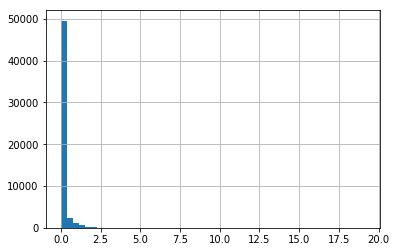

In [206]:
dataset.diff_TL.hist(bins=50)

In [467]:
thres = (1.5 * (dataset.diff_TL.quantile(0.75) - dataset.diff_TL.quantile(0.25))) + dataset.diff_TL.quantile(0.75)
thres, dataset.diff_TL.quantile(0.75), dataset.diff_TL.quantile(0.9)

(0.0007570404989692839, 0.0003028161997410287, 8.218295417905171)

In [468]:
len(dataset), len(dataset[dataset.diff_TL > 8.22])

(54191, 5417)

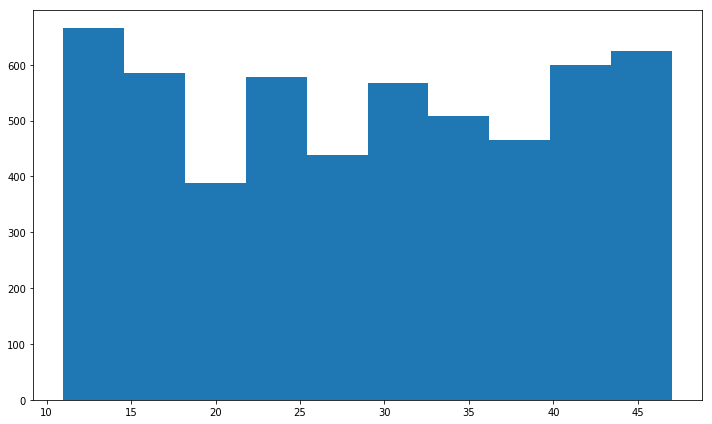

In [469]:
to_check = dataset[dataset.diff_TL > 8.21].copy()
to_check.hour_half.hist(grid=False, figsize=(10, 6))
plt.tight_layout()
plt.savefig('hourhist.png')

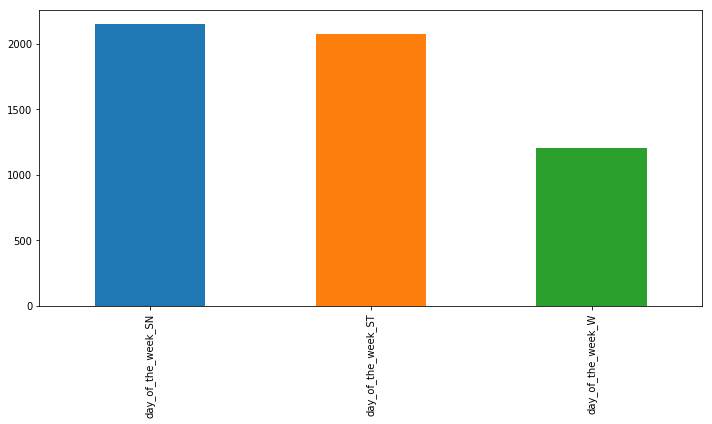

In [470]:
to_check[to_check.columns[:3]].sum(axis=0).plot(kind='bar',  figsize=(10, 6))
plt.tight_layout()
plt.savefig('bar1.png')

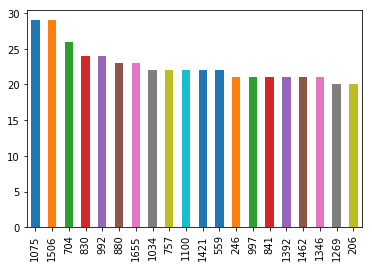

In [211]:
to_check.cell_number.value_counts()[:20].plot(kind='bar')
strange_cells = to_check.cell_number.value_counts()[:20].index.values

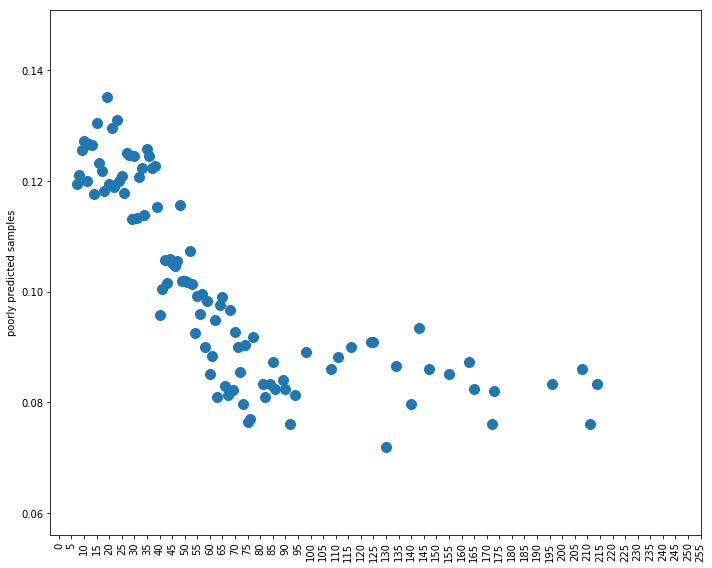

In [472]:
figure(figsize=(10, 8))
plt.scatter(to_check.n_cars.value_counts()[:100].index.values, to_check.n_cars.value_counts()[:100].values / tot_car_values,
           s=100)
plt.ylabel('poorly predicted samples')
plt.xticks(range(0, 260, 5), rotation=90);
plt.tight_layout()
plt.savefig('bar2.png')

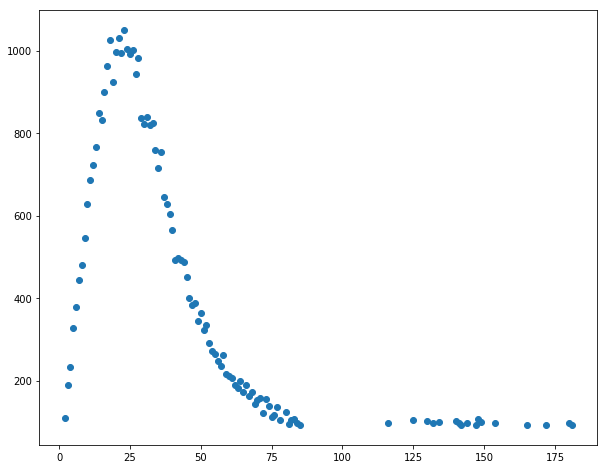

In [287]:
figure(figsize=(10, 8))
plt.scatter(dataset.n_cars.value_counts()[:100].index, dataset.n_cars.value_counts()[:100])
tot_car_values = dataset.n_cars.value_counts()[:100]

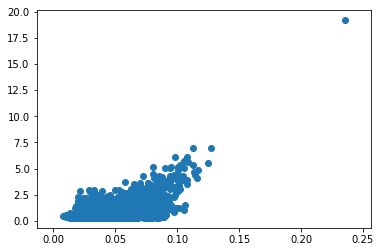

In [213]:
plt.scatter(to_check.TL.values, to_check.diff_TL.values)

In [306]:
stacked = dataset.iloc[:, :3].stack()
stacked = stacked[stacked == 1].reset_index(level=1)['level_1']
stacked = stacked.apply(lambda s: s[-2:])
pd.concat((dataset.iloc[:, [3,4,5, 11, 12, 13]], stacked), axis=1).rename(columns=
                                                                          {'level_1': 'weekday'}).to_csv('raw_values', index=False)

In [308]:
dataset[['TL', 'TL_pred']].describe()

,TL,TL_pred
count,54191.000000,54191.000000
mean,0.040548,0.040453
std,0.018298,0.017959
min,0.007582,0.007582
25%,0.028261,0.028466
50%,0.040678,0.040878
75%,0.052207,0.051967
max,0.352021,0.352021


In [214]:
plt.scatter(to_check.diff_TL.values, to_check.speed)

,day_of_the_week_SN,day_of_the_week_ST,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,TL,TL_pred,diff_TL
2524,1,0,0,16,45.02375,7.6325,0.04603,0.041451,284,17,4.245098,0.235566,0.043997,19.156902


10839
0.007758620689655172 0.0072203833


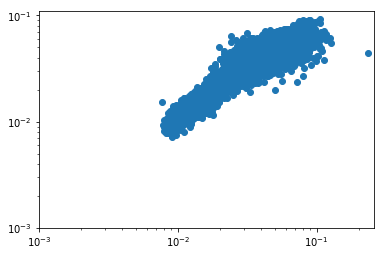

In [116]:
plt.scatter(y_test, model.predict(scaler.transform(X_test))/100)
plt.ylim(1e-3, )
plt.xlim(1e-3, )
plt.loglog()
print(len(X_test))
print(y_test.min(), (model.predict(scaler.transform(X_test))/100).min())

In [ ]:
val_losses = []
model_names = []

for h1 in range(15, 85, 5):
    for h2 in range(15, 100, 5):
        for is_h3 in [True, False]:
            for is_h4 in [True, False]:
                
                model = Sequential()
                model.add(Dense(h1, input_shape=(8, ), activation='relu'))
                model.add(Dense(h2, activation='relu'))
                if is_h3:
                    for h3 in range(3, 11):
                        model.add(Dense(h3, activation='relu'))
                        if is_h4:
                            for h4 in range(3, 11):
                                model.add(Dense(h4, activation='relu'))
                                model.add(Dense(1, ))
                                model.compile(loss='mean_squared_error', optimizer='adam')
                                v, n = practical_function(model, h1, h2, h3, h4)
                                val_losses.append(v)
                                model_names.append(n)
                        else:
                            model.add(Dense(1, ))
                            model.compile(loss='mean_squared_error', optimizer='adam')
                            v, n = practical_function(model, h1, h2, h3)
                            val_losses.append(v)
                            model_names.append(n)
                else:
                    model.add(Dense(1, ))
                    model.compile(loss='mean_squared_error', optimizer='adam')
                    v, n = practical_function(model, h1, h2)
                    val_losses.append(v)
                    model_names.append(n)    

In [386]:
def practical_function(model, h1, h2, h3=0, h4=0):
    filepath = 'neural_nets/weights_%d_%d_%d_%d.hdf5' % (h1, h2, h3, h4)
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                                 save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    hist = model.fit(X_trans, y_train*100, validation_split=0.2,
              epochs=120, batch_size=128, callbacks=callbacks_list, verbose=0)
                                
    model_json = model.to_json()
    modelpath = 'neural_nets/model_%d_%d_%d_%d.json' % (h1, h2, h3, h4)
    with open(modelpath, "w") as json_file:
        json_file.write(model_json)
    print(h1, h2, h3, h4)
    return min(hist.history['val_loss']), modelpath[12:]

In [376]:
# serialize model to JSON
model_json = model.to_json()
with open("neural_nets/random_try.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("neural_nets/random_try.hdf5")
print("Saved model to disk")

Saved model to disk


In [379]:
# load json and create model
json_file = open('neural_nets/random_try.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("neural_nets/random_try.hdf5")
print("Loaded model from disk")

Loaded model from disk


Text(0.5,1,'Median trip length per day hour')

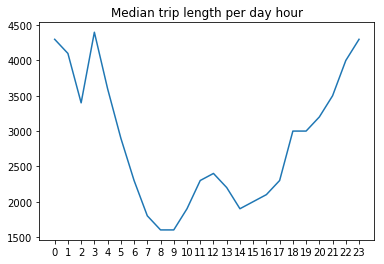

In [25]:
#fig = plt.figure(figsize=(20, 30))
#axes = fig.subplots(6, 4)
median_trip = []
for h in range(24):
    #i = h//4
    #j = h%4
    median_trip.append(turin_june[(turin_june.engine_status == 2) & (turin_june.hour == h)].meters.quantile(0.5))
    #.plot(kind='hist', ax=axes[i, j], #bins=15)
    
plt.plot(range(24), median_trip)
plt.xticks(range(24))
plt.title('Median trip length per day hour')

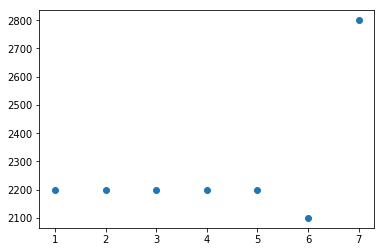

In [129]:
median_day_trip = []
for d in range(1, 8):
    median_day_trip.append(turin_june[(turin_june.engine_status == 2) &
                                  (turin_june.day_of_the_week == d)].meters.quantile(0.5))
    
plt.scatter(range(1, 8), median_day_trip)

In [ ]:
## Look at the trips

stop_coords = turin_june.loc[turin_june.engine_status == 1, ['lat', 'lon']].values

In [ ]:
plt.scatter(stop_coords[:, 1], stop_coords[:, 0])

In [149]:
from gmplot import gmplot

In [153]:
# Place map
gmap = gmplot.GoogleMapPlotter(45.07, 7.67, 13)


gmap.scatter(stop_coords[:10, 0], stop_coords[:10, 1], '#3B0B39', size=10, marker=False)

# Draw
gmap.draw("my_map.html")

In [94]:
a, b = st

In [66]:
coords = turin_june[turin_june.engine_status == 1].loc[:, ['lon', 'lat']].values

In [67]:
ti

array([[ 7.579479, 45.099049],
       [ 7.598485, 45.104286],
       [ 7.613513, 45.110054],
       ...,
       [ 7.636   , 45.115135],
       [ 7.636302, 45.115623],
       [ 7.636322, 45.11565 ]])

In [148]:
turin_june['hour_&_quarter'].unique()

array([datetime.time(6, 45), datetime.time(10, 30), datetime.time(10, 45),
       datetime.time(11, 45), datetime.time(12, 0), datetime.time(17, 45),
       datetime.time(18, 0), datetime.time(16, 45), datetime.time(17, 0),
       datetime.time(17, 15), datetime.time(20, 30),
       datetime.time(20, 45), datetime.time(6, 30), datetime.time(19, 0),
       datetime.time(19, 15), datetime.time(7, 0), datetime.time(18, 45),
       datetime.time(15, 30), datetime.time(11, 30),
       datetime.time(19, 30), datetime.time(6, 15), datetime.time(11, 0),
       datetime.time(4, 30), datetime.time(9, 30), datetime.time(9, 45),
       datetime.time(8, 30), datetime.time(16, 15), datetime.time(18, 30),
       datetime.time(12, 15), datetime.time(11, 15),
       datetime.time(18, 15), datetime.time(15, 45),
       datetime.time(17, 30), datetime.time(14, 0), datetime.time(14, 15),
       datetime.time(10, 15), datetime.time(15, 0), datetime.time(15, 15),
       datetime.time(4, 45), datetime.time(5

In [23]:
turin_june

,device_id,recording_date,lat,lon,speed,heading,gps_quality,engine_status,acceleration,meters,day,day_of_the_week,hour,hour_&_quarter
0,3100010,2017-06-01 06:45:38,45.099049,7.579479,103,68,8,1,0,14200,2017-06-01,4,6,06:45:00
1,3100010,2017-06-01 06:46:38,45.104286,7.598485,109,68,8,1,0,15800,2017-06-01,4,6,06:45:00
2,3100010,2017-06-01 06:47:19,45.110054,7.613513,122,56,8,1,0,17200,2017-06-01,4,6,06:45:00
3,3100010,2017-06-01 06:47:23,45.110573,7.614595,123,56,8,1,0,17300,2017-06-01,4,6,06:45:00
4,3100010,2017-06-01 06:47:38,45.113396,7.620533,128,56,8,1,0,17800,2017-06-01,4,6,06:45:00
5,3100010,2017-06-01 06:48:34,45.117565,7.637709,57,176,8,1,3,19400,2017-06-01,4,6,06:45:00
6,3100010,2017-06-01 06:48:38,45.117226,7.637706,16,180,8,1,0,19400,2017-06-01,4,6,06:45:00
7,3100010,2017-06-01 06:48:40,45.117191,7.637701,12,180,8,1,2,19500,2017-06-01,4,6,06:45:00
8,3100010,2017-06-01 06:48:59,45.115688,7.637361,35,266,8,1,3,19600,2017-06-01,4,6,06:45:00
9,3100010,2017-06-01 06:49:38,45.115749,7.635075,0,0,11,1,0,19800,2017-06-01,4,6,06:45:00


In [316]:
turin_june.cell_centroid_lat.min(), turin_june.cell_centroid_lat.max(), turin_june.cell_centroid_lon.min(), turin_june.cell_centroid_lon.max()

(45.00625, 45.14125, 7.5775000000000015, 7.7725)

In [390]:
newdat = pd.read_csv('raw_values.csv', usecols=['weekday'])
dataset['weekday'] = newdat.weekday.values

/Users/stefanocalde/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [407]:
colms = dataset.columns.tolist()[:11] + ['weekday']
colms

['day_of_the_week_SN',
 'day_of_the_week_ST',
 'day_of_the_week_W',
 'hour_half',
 'cell_centroid_lat',
 'cell_centroid_lon',
 'tl_neighs',
 'tl_prev_half',
 'cell_number',
 'n_cars',
 'speed',
 'weekday']

In [438]:
## Try two other things
import numpy as np

dataset_11 = dataset[dataset.hour_half == 11].copy()
cut_dataset = dataset[dataset.hour_half != 11][colms].copy()
cut_dataset.tl_neighs = np.nan
cut_dataset.tl_prev_half = np.nan

bad_cells = []
for d in ['SN', 'ST', 'W']:
    for h in range(12, 48):
        for c in dataset_11.cell_number.unique():
            if c in bad_cells:
                print(bad_cells)
                continue
            if h == 12:
                df = dataset_11
            else:
                df = cut_dataset.loc[cut_dataset.hour_half == h - 1]
         
            condition = (df.cell_number == c) & (df.weekday == d)
            check = 0
            if not len(df[condition]):
                bad_cells.append(c)
                continue
            n = find_neighbours(c)
            #print(n)
            condition2 = (df.cell_number.isin(n)) & (df.weekday == d) & (df.hour_half == h - 1)
            check = 0
            if not len(df[condition2]):
                bad_cells.append(c)
                continue
            #if not len(dataset[(dataset.cell_number == c) & (dataset.weekday == d) & (dataset.hour_half == h - 1)]):
                #continue
            #print(c)
            #print(h, df.loc[condition, df.columns[:8]])
            print(len(df[condition]))
            input_data = scaler2.transform(df.loc[condition, df.columns[:8]].values)
            prev_tl = np.power(np.e, extree.predict(input_data))
            if prev_tl >= 2:
                prev_tl = 1.98
            input_data2 = scaler2.transform(df.loc[condition2, df.columns[:8]].values)
            neighs_tl = np.mean(np.power(np.e, extree.predict(input_data2)))
            if neighs_tl >= 2:
                neighs_tl = 1.98
                
            #print(h, h, h)
            condition = (cut_dataset.cell_number == c) & (cut_dataset.weekday == d) & (cut_dataset.hour_half == h)
            cut_dataset.loc[condition, 'tl_neighs'] = neighs_tl
            cut_dataset.loc[condition, 'tl_prev_half'] = prev_tl
        print('Did hour %d' %h)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Did hour 12
1


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [437]:
cut_dataset[cut_dataset.cell_number == 46]

,day_of_the_week_SN,day_of_the_week_ST,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,weekday
494,1,0,0,12,45.00875,7.6125,0.015881,0.009088,46,15,112.266667,SN
993,1,0,0,13,45.00875,7.6125,NaN,NaN,46,12,91.055556,SN
1493,1,0,0,14,45.00875,7.6125,NaN,NaN,46,19,100.210526,SN
1993,1,0,0,15,45.00875,7.6125,NaN,NaN,46,19,99.894737,SN
2493,1,0,0,16,45.00875,7.6125,NaN,NaN,46,26,98.634615,SN
2993,1,0,0,17,45.00875,7.6125,NaN,NaN,46,39,96.027778,SN
3493,1,0,0,18,45.00875,7.6125,NaN,NaN,46,39,100.444444,SN
3993,1,0,0,19,45.00875,7.6125,NaN,NaN,46,28,92.035714,SN
4493,1,0,0,20,45.00875,7.6125,NaN,NaN,46,35,106.238095,SN
4993,1,0,0,21,45.00875,7.6125,NaN,NaN,46,25,97.420000,SN


In [394]:
r2_score(y_test, extree.predict(scaler2.transform(X_test)))

0.9172046766466174

In [381]:
scaler2 = MinMaxScaler().fit(X_train)

In [395]:
from sklearn.externals import joblib
joblib.dump(scaler2, 'scaler_minmax.pkl') 
joblib.dump(extree, 'regressor.pkl') 

['regressor.pkl']

In [398]:
dataset.describe()

,day_of_the_week_SN,day_of_the_week_ST,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,TL,TL_pred,diff_TL
count,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,5.419100e+04
mean,0.320717,0.337897,0.341385,29.057611,45.071561,7.661910,0.040894,0.040652,1035.729106,84.597461,33.294754,0.040548,0.040453,9.801722e-02
std,0.466757,0.472998,0.474179,10.478437,0.029332,0.035133,0.015929,0.020826,459.881762,96.846761,23.356890,0.018298,0.017959,3.334524e-01
min,0.000000,0.000000,0.000000,11.000000,45.008750,7.577500,0.007812,0.007246,46.000000,7.000000,2.840741,0.007582,0.007582,0.000000e+00
25%,0.000000,0.000000,0.000000,20.000000,45.051250,7.637500,0.032867,0.028175,712.000000,23.000000,19.154597,0.028261,0.028466,8.437695e-15
50%,0.000000,0.000000,0.000000,29.000000,45.071250,7.662500,0.043111,0.040665,1039.000000,40.000000,24.583333,0.040678,0.040878,1.865175e-14
75%,1.000000,1.000000,1.000000,38.000000,45.093750,7.687500,0.050570,0.052242,1393.000000,119.000000,35.384984,0.052207,0.051967,1.229227e-05
max,1.000000,1.000000,1.000000,47.000000,45.138750,7.767500,0.527378,2.000000,2100.000000,762.000000,131.888889,0.352021,0.352021,1.915690e+01
